In [1]:
import sys
sys.path.append('/Users/gregmartinez/.local/share/virtualenvs/mtg_scraper-N8QFuhGA/lib/python3.8/site-packages/')

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom_test, ttest_1samp, chi2_contingency, ttest_ind, f_oneway
from matplotlib.backends.backend_pdf import PdfPages
import re
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)

In [4]:
FLAT_FILE_DIR = "../flat_files/"

full_table = pd.read_csv(FLAT_FILE_DIR + "full_table.csv")
event_table = pd.read_csv(FLAT_FILE_DIR + "event_table.csv")
deck_list_table = pd.read_csv(FLAT_FILE_DIR + "deck_list_table.csv")
pilot_table = pd.read_csv(FLAT_FILE_DIR + "pilot_table.csv")
deck_table = pd.read_csv(FLAT_FILE_DIR + "deck_table.csv")
card_table = pd.read_csv(FLAT_FILE_DIR + "card_table.csv")

event_table["date"] = pd.to_datetime(event_table["date"])
full_table["date"] = pd.to_datetime(full_table["date"])
deck_table["rank"] = pd.to_numeric(deck_table["rank"])

In [5]:
deck_table.tail(25)

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category
3870,3871,726,1534,?e=29619&d=432414&f=ST,Naya Aggro,2,aggro,naya
3871,3872,726,482,?e=29619&d=432415&f=ST,Sultai Yorion Ultimatum,3,ramp,sultai
3872,3873,726,2157,?e=29619&d=432416&f=ST,Temur Aggro,3,aggro,temur
3873,3874,726,2158,?e=29619&d=432417&f=ST,Gruul Aggro,5,aggro,gruul
3874,3875,726,692,?e=29619&d=432420&f=ST,Jund,5,jund,jund
3875,3876,726,2159,?e=29619&d=432418&f=ST,Red Deck Wins,5,aggro,mono red
3876,3877,726,2160,?e=29619&d=432419&f=ST,Sultai Yorion Ultimatum,5,ramp,sultai
3877,3878,727,2161,?e=29620&d=432429&f=ST,Weenie White,1,aggro,mono white
3878,3879,727,1753,?e=29620&d=432430&f=ST,Sultai Yorion Ultimatum,2,ramp,sultai
3879,3880,727,2100,?e=29620&d=432431&f=ST,Dimir Control,3,control,dimir


In [6]:
event_table.tail(25)

,eventId,name,link,date,latest_set
704,705,Silver Series @ Lotus eSports,https://www.mtgtop8.com/event?e=29557&f=ST,2021-03-08,Kaldheim
705,706,Free Daily Bo1 @ Owl Central Games,https://www.mtgtop8.com/event?e=29559&f=ST,2021-03-08,Kaldheim
706,707,Season 1 Daily Trial @ BIG Magic,https://www.mtgtop8.com/event?e=29561&f=ST,2021-03-08,Kaldheim
707,708,Ligue Mars #2 @ Torino Tournament,https://www.mtgtop8.com/event?e=29562&f=ST,2021-03-08,Kaldheim
708,709,Tournament @ On Curve Events,https://www.mtgtop8.com/event?e=29567&f=ST,2021-03-10,Kaldheim
709,710,Event @ Lotus eSports,https://www.mtgtop8.com/event?e=29570&f=ST,2021-03-09,Kaldheim
710,711,Season 1 Daily Trial @ BIG Magic,https://www.mtgtop8.com/event?e=29571&f=ST,2021-03-09,Kaldheim
711,712,Gentry ! @ The Gentry Magic League,https://www.mtgtop8.com/event?e=29576&f=ST,2021-03-09,Kaldheim
712,713,Grinch Melee @ MTGA,https://www.mtgtop8.com/event?e=29584&f=ST,2021-03-10,Kaldheim
713,714,"Event @ Taverna Geek (Santos, Brasil)",https://www.mtgtop8.com/event?e=29591&f=ST,2021-03-09,Kaldheim


In [7]:
LANDS = ["Island", "Mountain", "Forest", "Plains", "Swamp"]
def get_illegal_decks():
    return full_table[
        ~full_table["cardId"].isin(
            card_table[card_table["standardLegality"] == "legal"]["cardId"]
        )
    ]["deckId"]

def get_first_place_decks():
    illegal_decks = get_illegal_decks()
    return deck_table[
        (deck_table["rank"]==1)
        & (~deck_table["deckId"].isin(illegal_decks))
    ].copy()

def get_main_decks():
    illegal_decks = get_illegal_decksdecks()
    return full_table[
        (~full_table["name"].isin(LANDS))
        & (~full_table["deckId"].isin(illegal_decks))
        & (full_table["slot"] == "md")
    ].copy()

In [8]:
# Common Slices
illegal_decks = full_table[
    ~full_table["cardId"].isin(card_table[card_table["standardLegality"] == "legal"]["cardId"])
]["deckId"]

first_place_decks = deck_table[
    (deck_table["rank"] == 1)
    & ~(deck_table["deckId"].isin(illegal_decks))
].copy()
main_decks = full_table[
    (~full_table["name"].isin(["Island", "Mountain", "Forest", "Plains", "Swamp"]))
    & (full_table["slot"] == "md")
    & ~(full_table["deckId"].isin(illegal_decks))
].copy()


In [9]:
def get_most_used_cards(df):
    grouped_table = (
        df
        .copy()
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(main_decks["deckId"].nunique())
    
    return grouped_table

most_used_cards = get_most_used_cards(main_decks)

In [10]:
main_decks.drop_duplicates(subset=["deckId"])["name_deck"].value_counts()

Gruul Aggro                   581
Red Deck Wins                 261
Mono Green Aggro              239
Dimir Mill                    229
Rakdos Aggro                  185
Esper DOOM Yorion             168
Naya Aggro                    131
Sultai Yorion Ultimatum       126
Dimir Control                 122
Boros Cycling Aggro           105
Dimir Rogue                    87
Temur Ramp Ultimatum           81
Weenie White                   70
UB Control                     62
Izzet Control                  60
Gruul Adventure Aggro          55
Selesnya Aggro                 53
Golgari Aggro                  51
Temur Ultimatum                42
Temur Aggro Adventure          40
UW Control                     39
Jund                           38
Grixis Control                 30
UB Mill                        26
Rakdos Control                 26
Dimir Aggro                    23
Mono Black Aggro               22
Weenie White                   21
Temur Ramp Ultimatum \t        20
Sultai Yorion 

In [11]:
pd.merge(first_place_decks, full_table[["deckId", "date"]], on="deckId").drop_duplicates()

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category,date
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,gruul,2020-10-30
22,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,mono red,2020-10-30
42,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,rakdos,2020-10-30
71,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,gruul,2020-10-29
98,13,5,15,?e=27918&d=421478&f=ST,Rakdos Control,1,control,rakdos,2020-10-28
126,17,6,19,?e=27921&d=421484&f=ST,Gruul Aggro,1,aggro,gruul,2020-10-28
152,25,7,26,?e=27886&d=421193&f=ST,UW Control,1,control,azorius,2020-10-27
187,27,8,28,?e=27898&d=421353&f=ST,Rakdos Control,1,control,rakdos,2020-10-27
213,31,9,32,?e=27901&d=421373&f=ST,Dimir Mill,1,mill,dimir,2020-10-27
242,39,10,39,?e=27902&d=421381&f=ST,Izzet Control,1,control,izzet,2020-10-27


In [12]:
def most_winning_archetypes(show=False):
    df = pd.merge(first_place_decks, full_table[["deckId", "date"]], on="deckId").drop_duplicates()
    grouped_archetypes = df[df["date"].dt.year == 2021].groupby("archetype")["rank"].sum().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    plt.bar(range(len(grouped_archetypes)), grouped_archetypes["rank"])
    plt.xticks(range(len(grouped_archetypes)), grouped_archetypes["archetype"], rotation=30, ha="right")
    plt.title("Most Winning Archetypes")
    if show:
        plt.show()

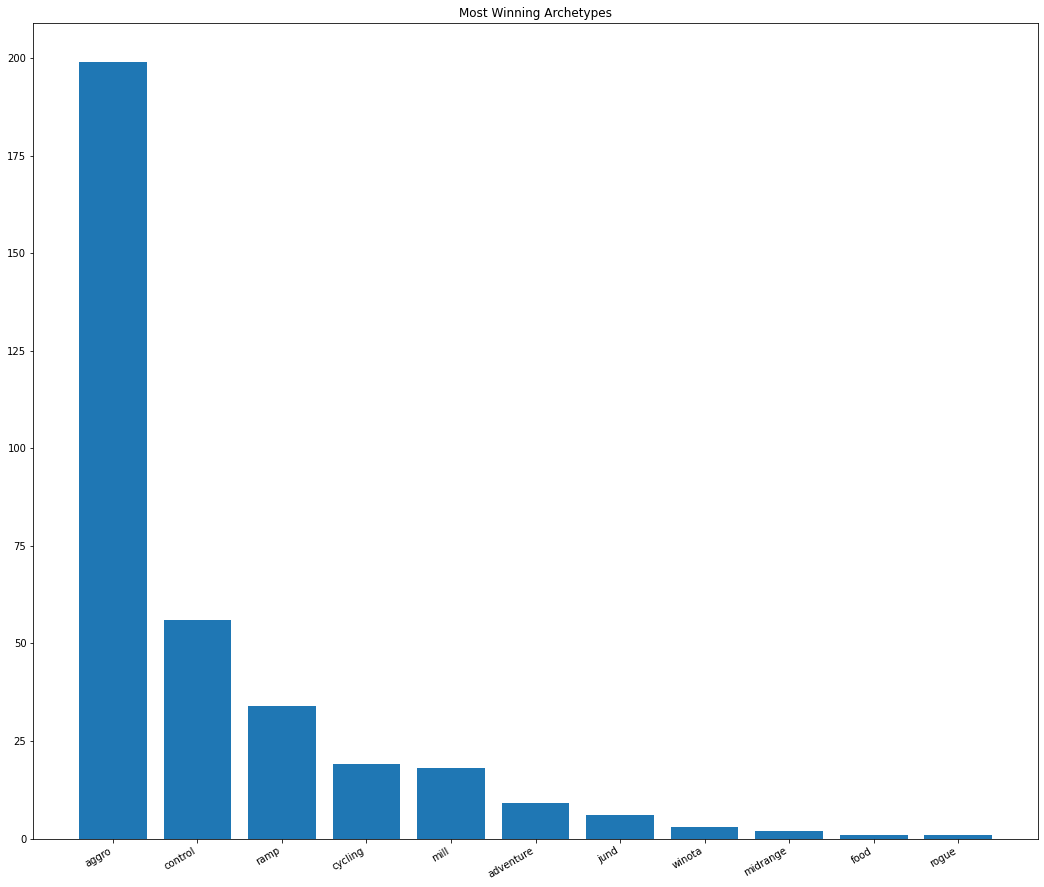

In [13]:
most_winning_archetypes(show=True)

In [14]:
def most_winning_archetypes_last_2_months(df, show=False):
    last_2_months = df[df["event_date"]]

In [15]:
def most_winning_colors(df, show=False):
    grouped_category = df.groupby("category")["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_category, x="category", y="rank")
    plt.title("Most Winning Colors")
    plt.xticks(rotation=30, ha="right")
    if show:
        plt.show()

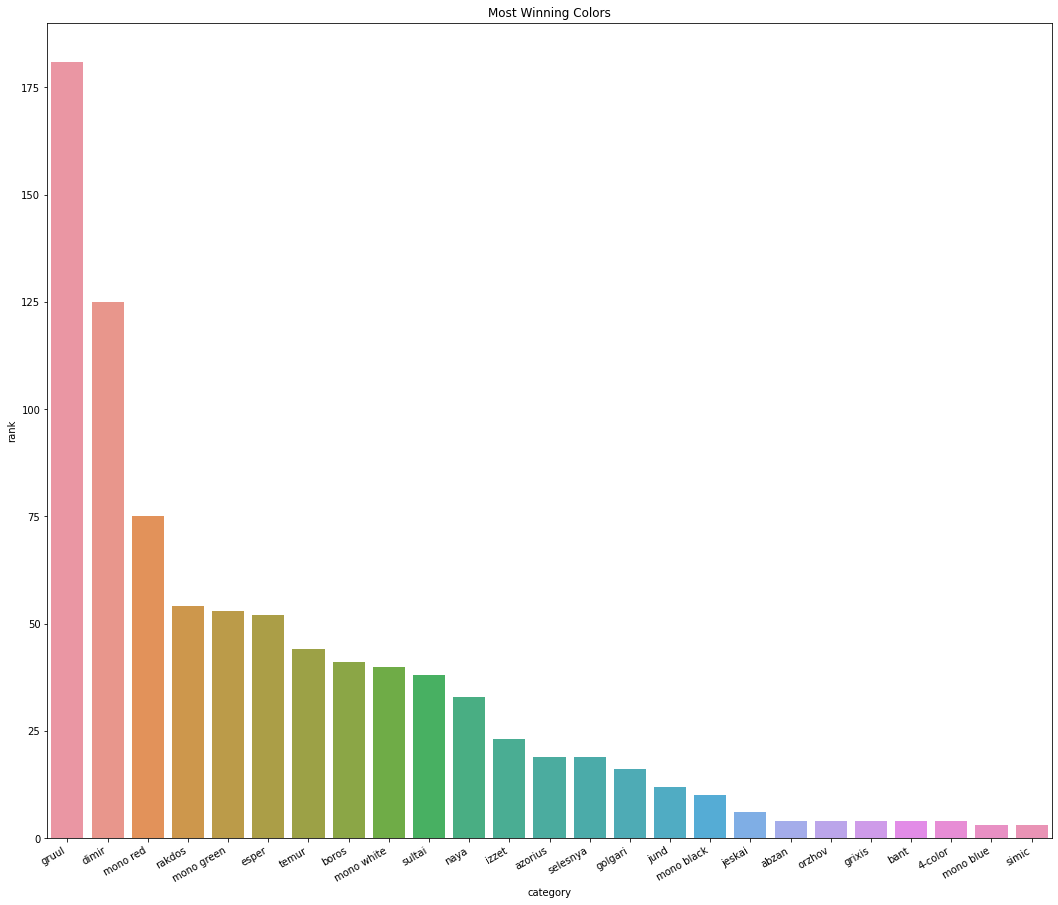

In [16]:
most_winning_colors(first_place_decks)

In [17]:
def most_winning_colors_by_set(df, show=False):
    merged_table = df.merge(event_table[["eventId", "latest_set"]], on="eventId", suffixes=[None, "_event"])
    grouped_table = merged_table.groupby(["category", "latest_set"])["rank"].count().reset_index().sort_values(by="rank", ascending=False)
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank", hue="latest_set")
    plt.title("Most Winning Colors During Each Set")
    plt.xlabel("")
    plt.ylabel("Number of Decks")
    plt.xticks(rotation=45, ha="right")
    if show:
        plt.show()

# most_winning_colors_by_set(first_place_decks, show=True)

In [18]:
def what_colors_go_with_archetype(archetypes, colors):
    archetypes = deck_table[deck_table["archetype"].isin(archetypes)]["archetype"]
    colors = deck_table[deck_table["category"].isin(colors)]["category"]
    frequencies = pd.crosstab(archetypes, colors)
    chi2, pval, _, expected = chi2_contingency(frequencies)
    return chi2, pval, frequencies, expected

# what_colors_go_with_archetype(["aggro"], ["mono green", "gruul"])

In [19]:
def colors_and_archetypes(df, archetype, show=False):
    df_archetype = df[df["archetype"] == archetype].copy()
    grouped_table = (
        df_archetype
        .groupby("category")["rank"]
        .count()
        .reset_index()
        .sort_values(by="rank", ascending=False)
    )
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table, x="category", y="rank")
    plt.title(f"Categories in the Most Winning {archetype.title()} Decks")
    plt.xlabel("")
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("Number of Decks")
    if show:
        plt.show()

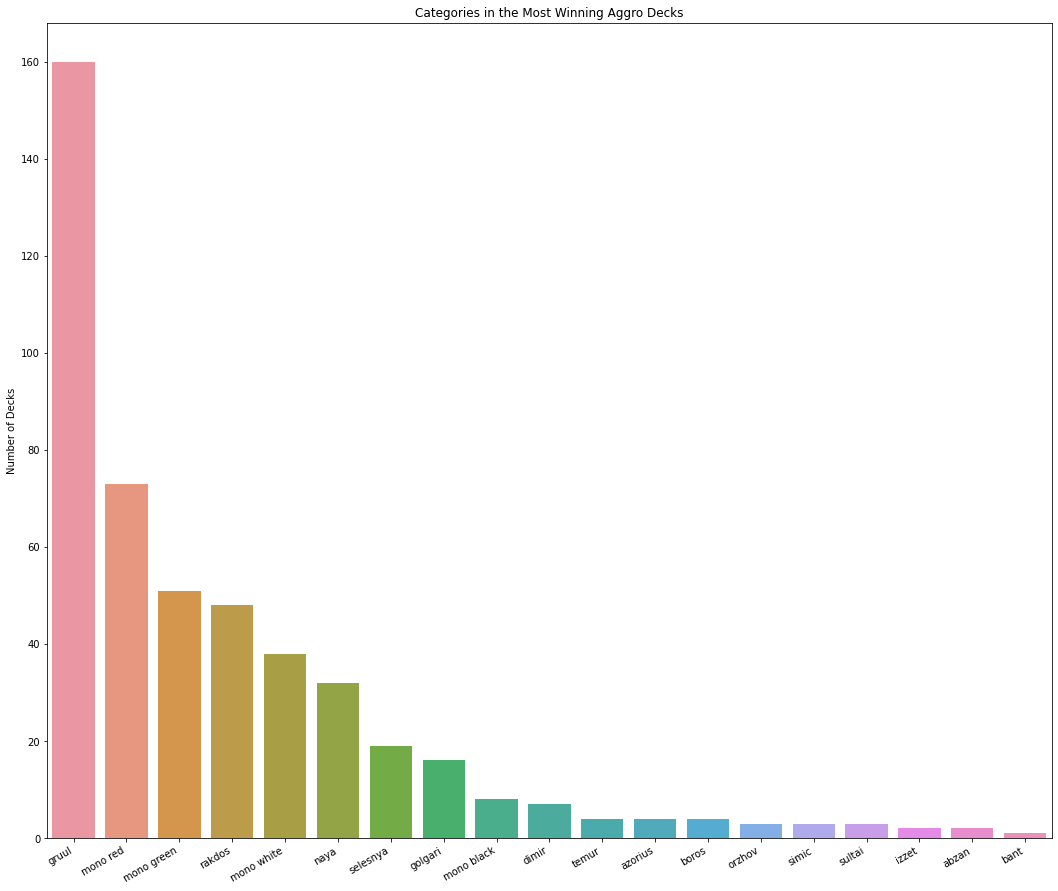

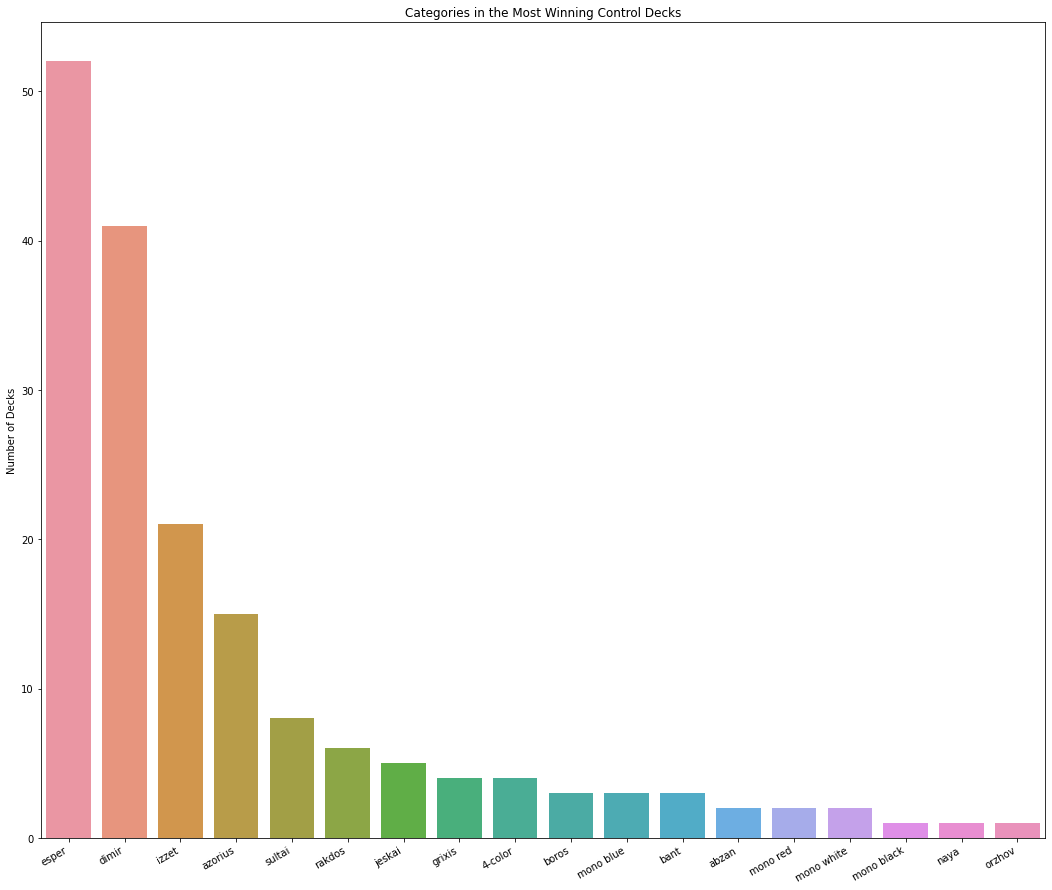

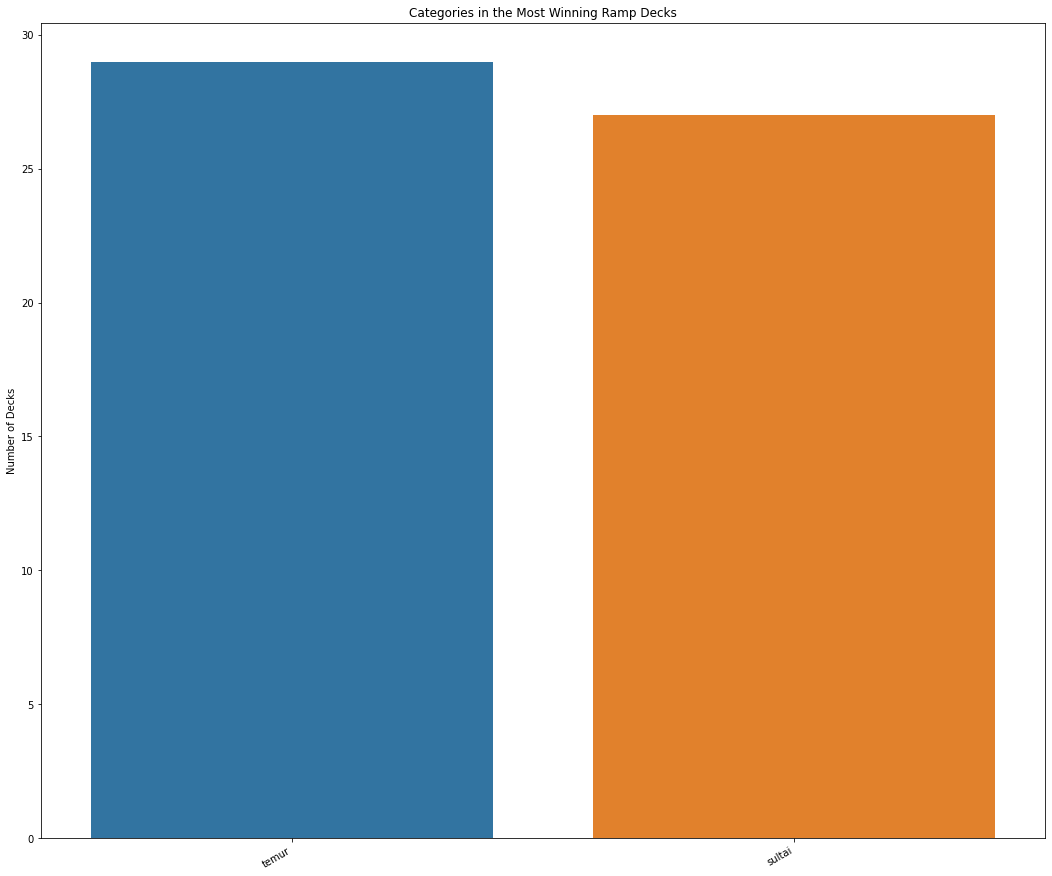

In [20]:
def topn_colors_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n].tolist()
    for archetype in topn_archetypes:
        colors_and_archetypes(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_colors_archetypes(first_place_decks, show=True, n=3)

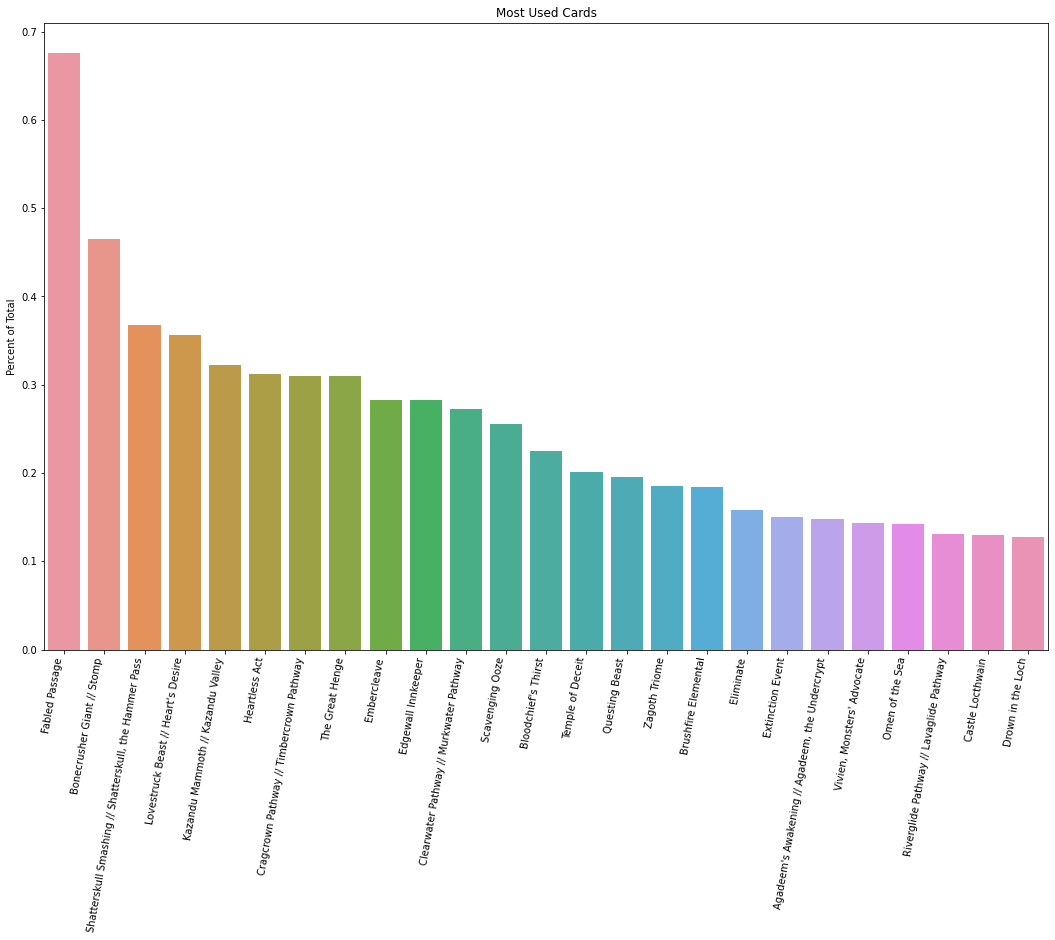

In [21]:
def most_used_cards_graphics(df, show=False):
    this_full_table = df.copy()
    grouped_table = (
        this_full_table
        .groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_table["pct_total"] = grouped_table["deckId"].div(this_full_table["deckId"].nunique())
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_table.iloc[:25], x="name", y="pct_total")
    plt.title("Most Used Cards")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80, ha="right")
    plt.xlabel("")
    plt.ylabel("Percent of Total")
    if show:
        plt.show()
    
most_used_cards_graphics(main_decks, show=True)

In [22]:
def most_used_cards_in_archetype(df, archetype, show=False):
    this_df = df[df["archetype"] == archetype].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:30], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=80, horizontalalignment="right")
    plt.title(f"Most Used Cards in {archetype.title()} Decks")
    plt.ylabel("Percent of All Cards")
    plt.xlabel("")
    if show:
        plt.show()

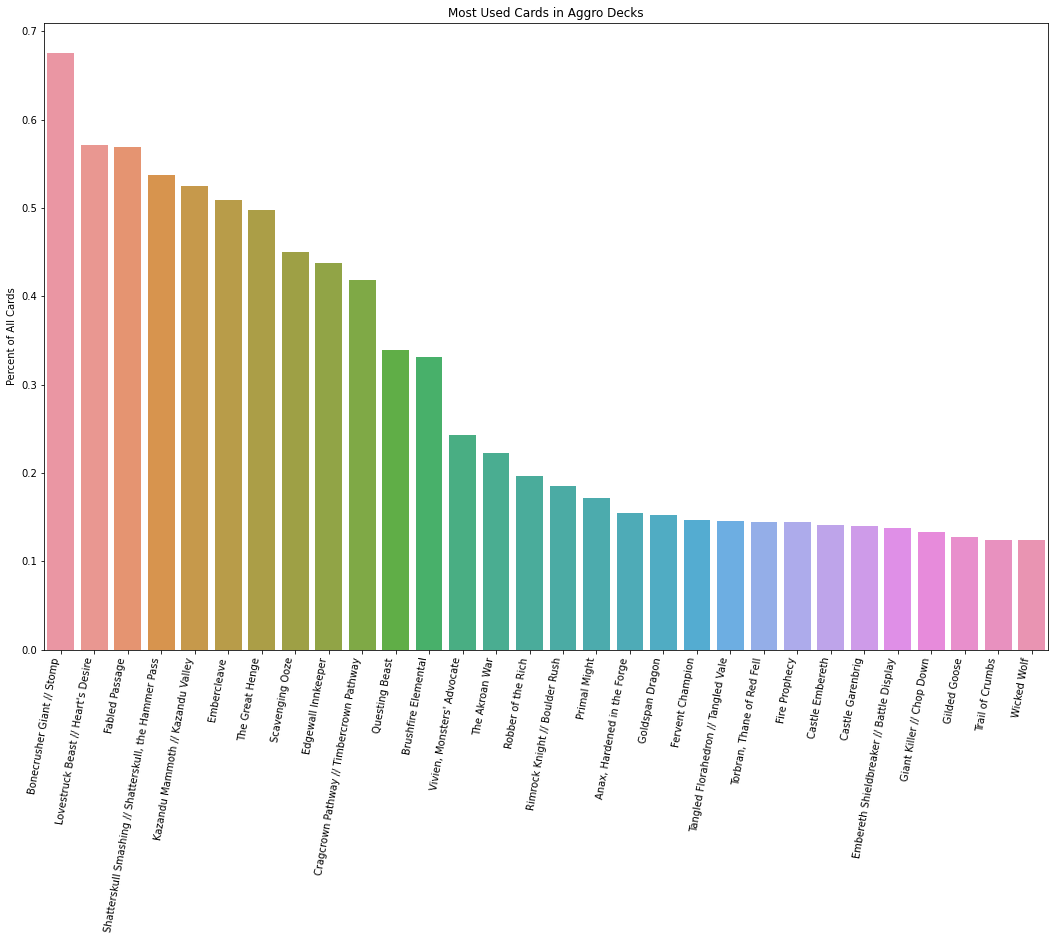

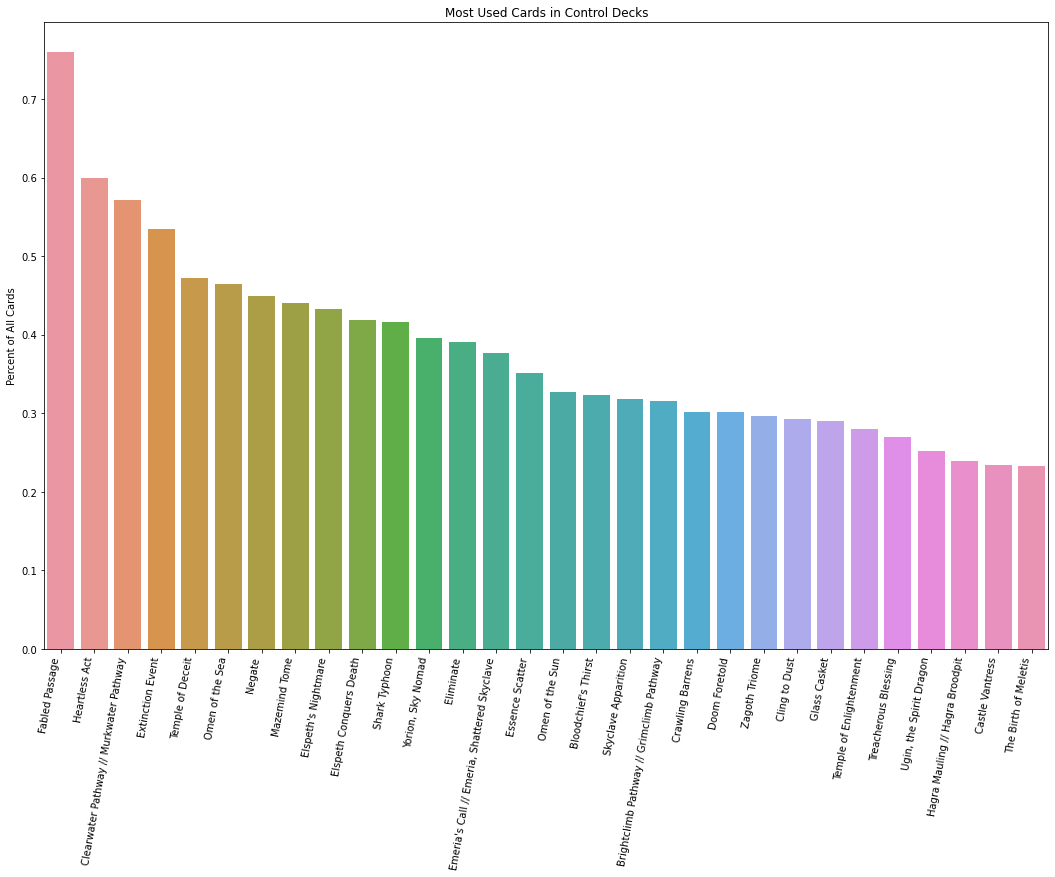

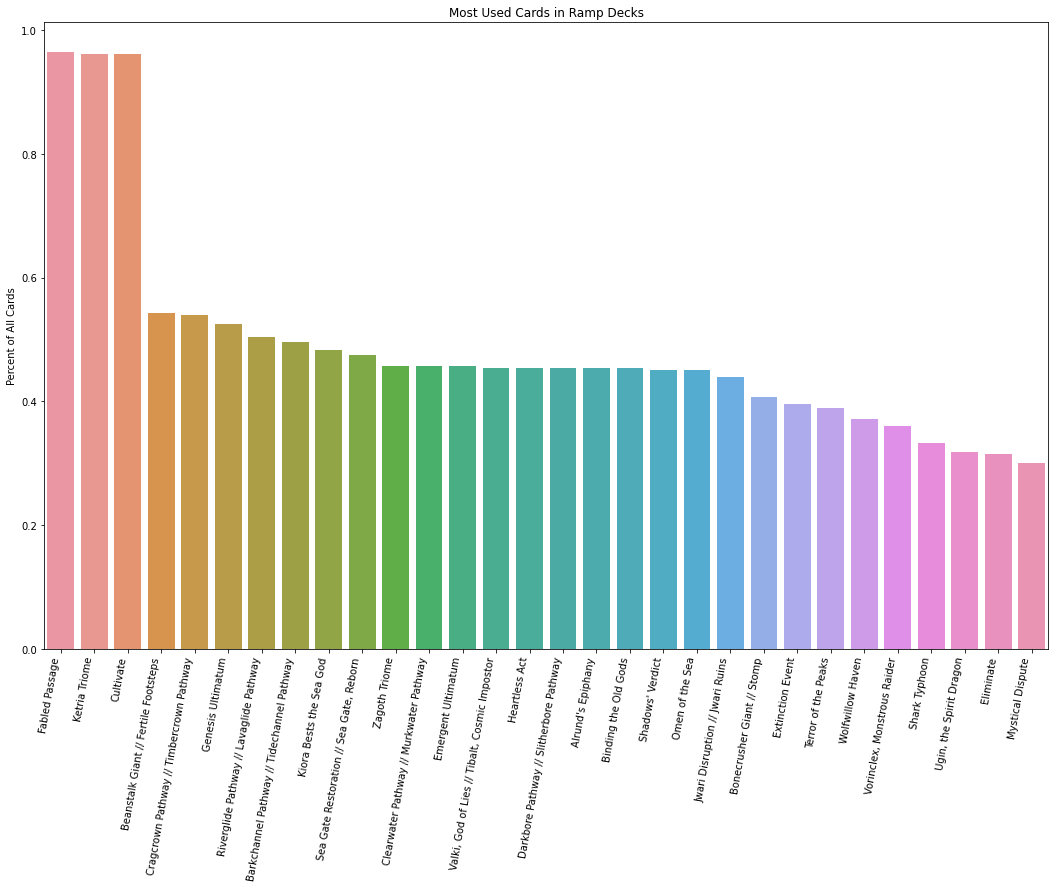

In [23]:
def topn_archetypes(df, n=10, show=False, pdf=None):
    topn_archetypes = deck_table["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        most_used_cards_in_archetype(df, archetype, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_archetypes(main_decks, n=3, show=True)

In [24]:
def most_used_cards_in_category(df, category, show=False):
    this_df = df[df["category"] == category].copy()
    grouped_df = (
        this_df.groupby("name")["deckId"]
        .nunique()
        .reset_index()
        .sort_values(by="deckId", ascending=False)
    )
    grouped_df["pct_total"] = grouped_df["deckId"] / this_df["deckId"].nunique()
    plt.figure(figsize=(18, 15))
    sns.barplot(data=grouped_df.iloc[:25], x="name", y="pct_total")
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"The Top Cards for {category.title()} Decks")
    plt.ylabel("Percent of Total Decks")
    plt.xlabel("")
    plt.xticks(rotation=80)
    if show:
        plt.show()

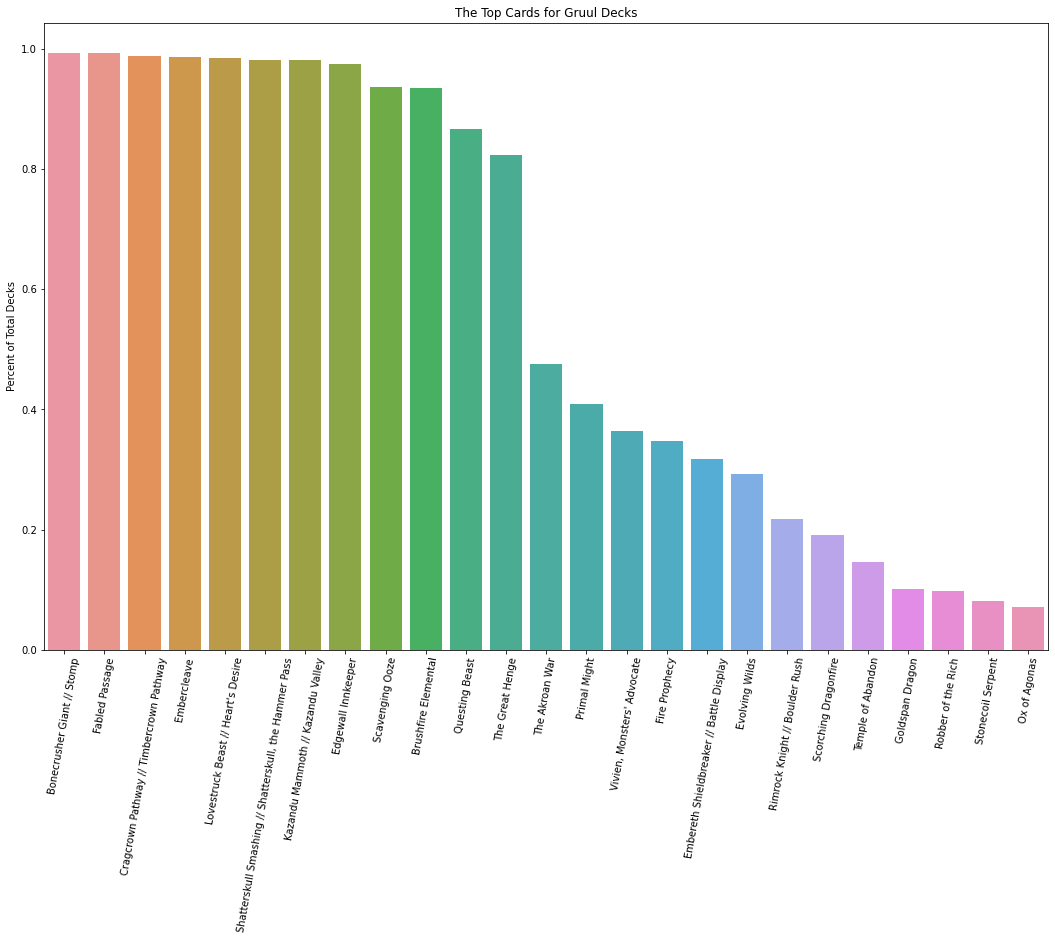

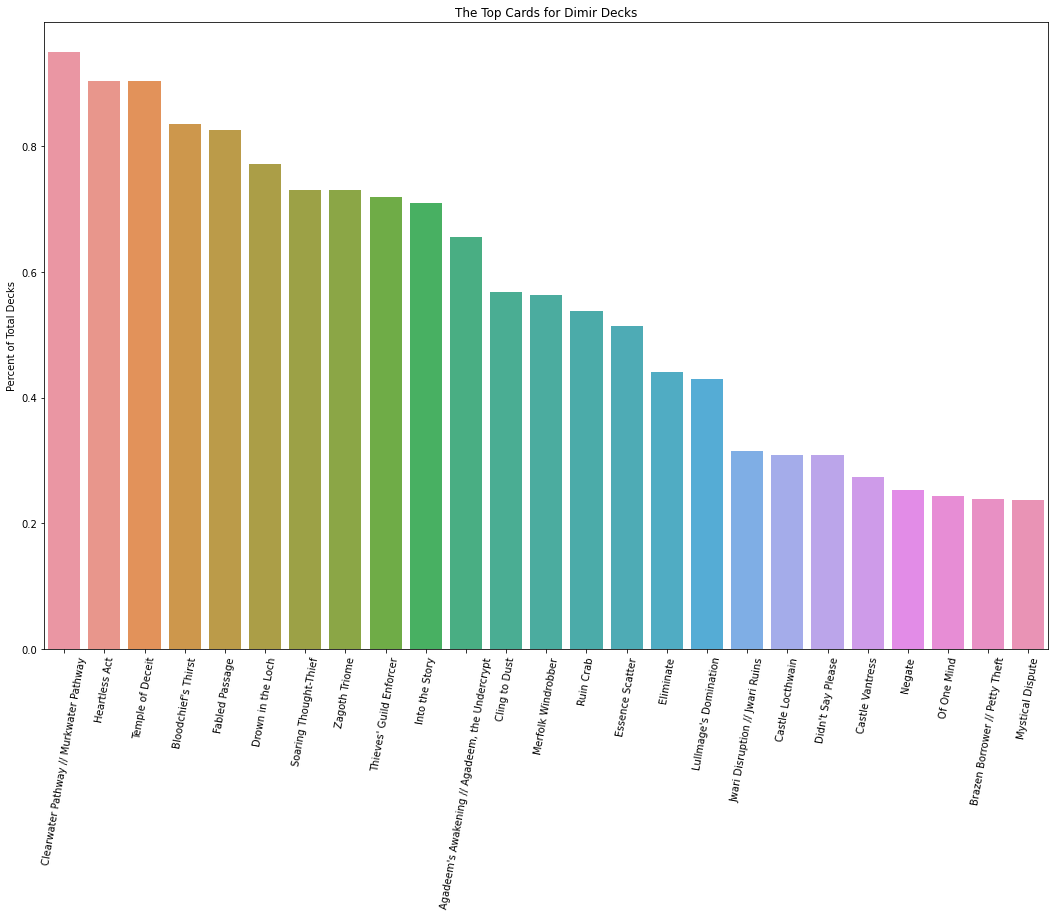

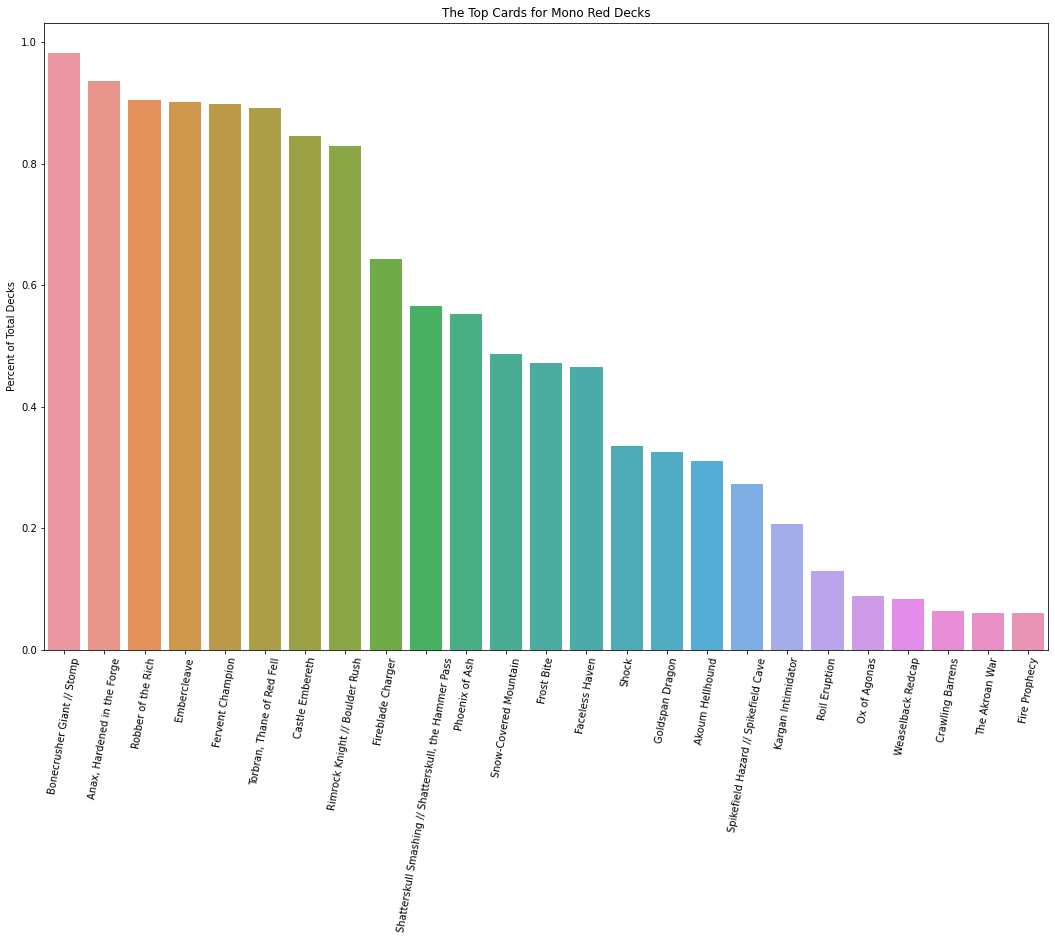

In [25]:
def topn_categories(df, n=10, show=False, pdf=None):
    topn_categories = deck_table["category"].value_counts().index[:n]
    for category in topn_categories:
        most_used_cards_in_category(df, category, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

topn_categories(main_decks, n=3, show=True)

In [26]:
def cards_by_set(df, unique_cards=False, show=False):
    this_df = df[df["deckId"].isin(first_place_decks["deckId"])].copy()
    title = "Cards"
    if unique_cards:
        this_df.drop_duplicates(subset="name", inplace=True)
        title="Unique Cards"
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    plt.figure(figsize=(18, 15))
    sns.countplot(x=this_df["set"], order=this_df["set"].value_counts().index)
    plt.title(f"{title} Used Per Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()
    

In [27]:
first_place_decks

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,gruul
2,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,mono red
3,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,rakdos
4,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,gruul
12,13,5,15,?e=27918&d=421478&f=ST,Rakdos Control,1,control,rakdos
16,17,6,19,?e=27921&d=421484&f=ST,Gruul Aggro,1,aggro,gruul
24,25,7,26,?e=27886&d=421193&f=ST,UW Control,1,control,azorius
26,27,8,28,?e=27898&d=421353&f=ST,Rakdos Control,1,control,rakdos
30,31,9,32,?e=27901&d=421373&f=ST,Dimir Mill,1,mill,dimir
38,39,10,39,?e=27902&d=421381&f=ST,Izzet Control,1,control,izzet


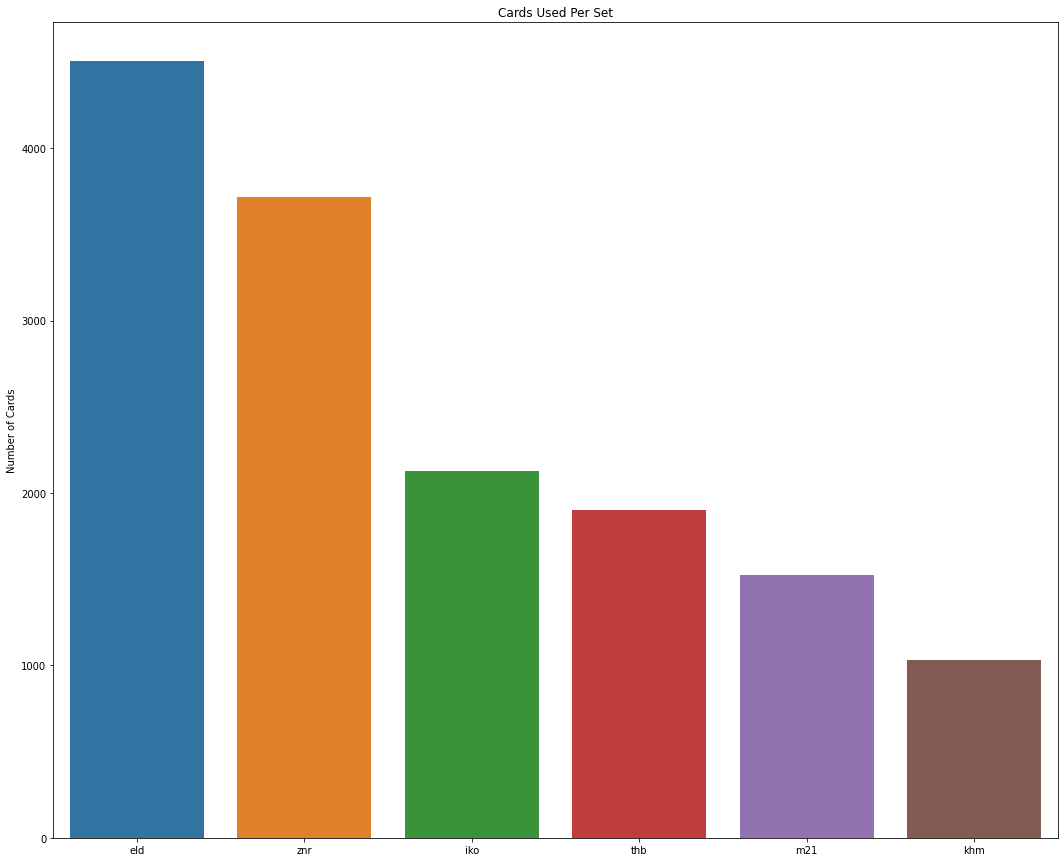

In [28]:
cards_by_set(main_decks,show=True)

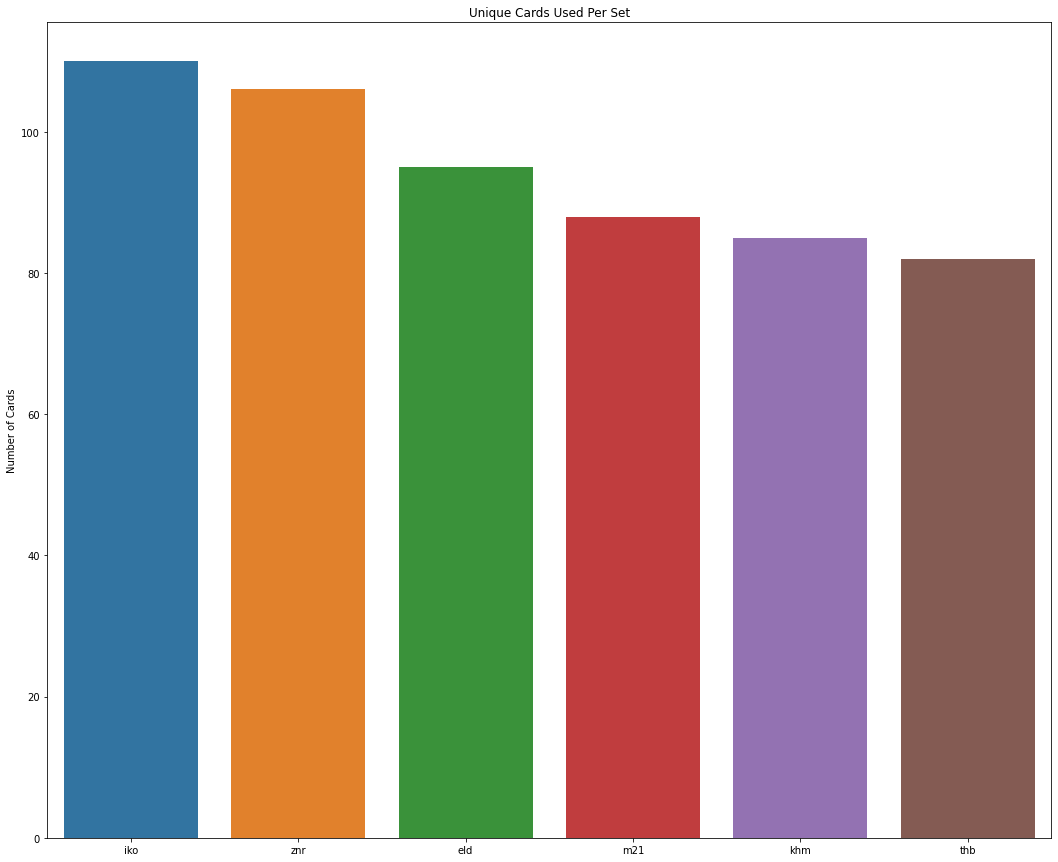

In [29]:
cards_by_set(main_decks,unique_cards=True, show=True)

In [30]:
def sort_by_date(df):
    date_order = []
    for year in ["2020", "2021"]:
        for month in [
            "January", "February", "March", "April", 
            "May", "June", "July", "August", 
            "September", "October", "November", "December"
        ]:
            date_order.append(f"{month} {year}")
    this_df = df.copy()
    
    this_df["month_year"] = pd.Categorical(
        this_df["date"].dt.month_name() + " " + (this_df["date"].dt.year).astype("str"),
        date_order,
        ordered=True
    )
    
    this_df["day"] = this_df["date"].dt.day
    
    return this_df.sort_values(by=["month_year", "day"])

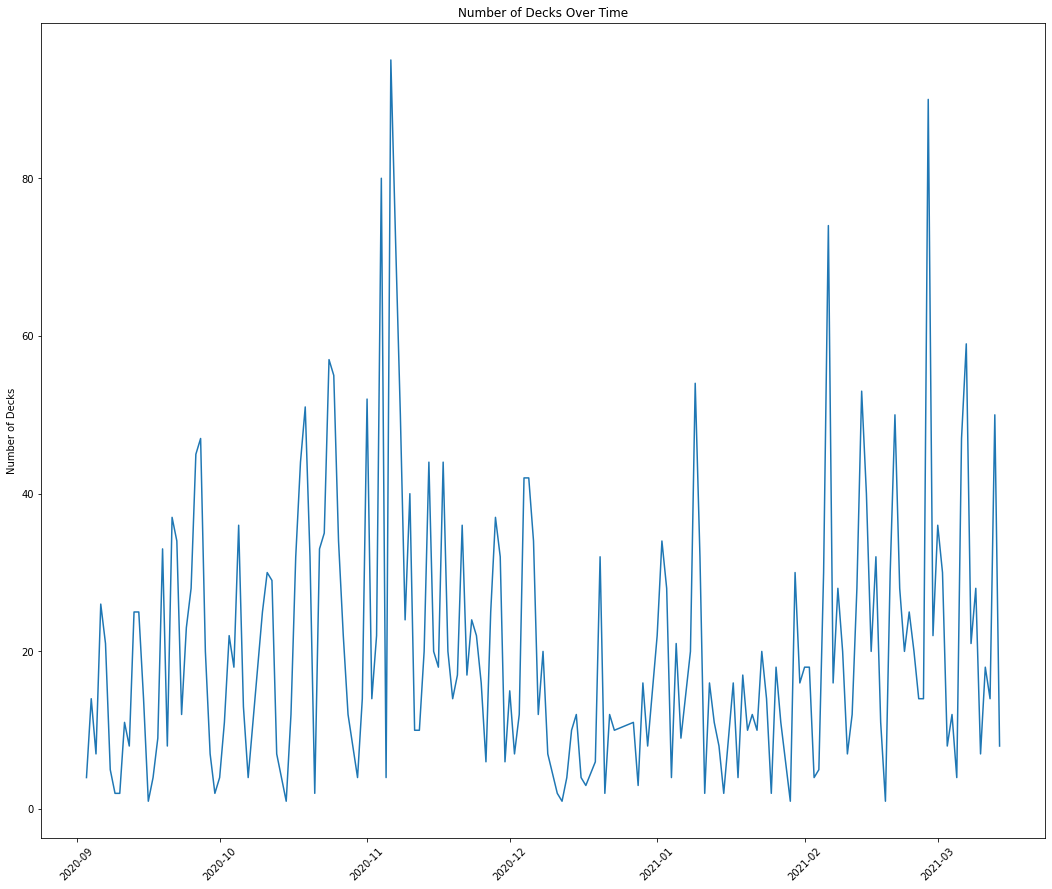

In [31]:
def number_of_decks_over_time(df, show=False):
    this_df = sort_by_date(df)
    grouped_df= (
        this_df
        .groupby(["date"])["deckId"]
        .nunique()
        .reset_index()
    )
    
    plt.figure(figsize=(18, 15))
    plt.plot(grouped_df["date"], grouped_df["deckId"])
    plt.xticks(rotation=45)
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks Over Time")
    if show:
        plt.show()
    
    
number_of_decks_over_time(full_table, show=True)

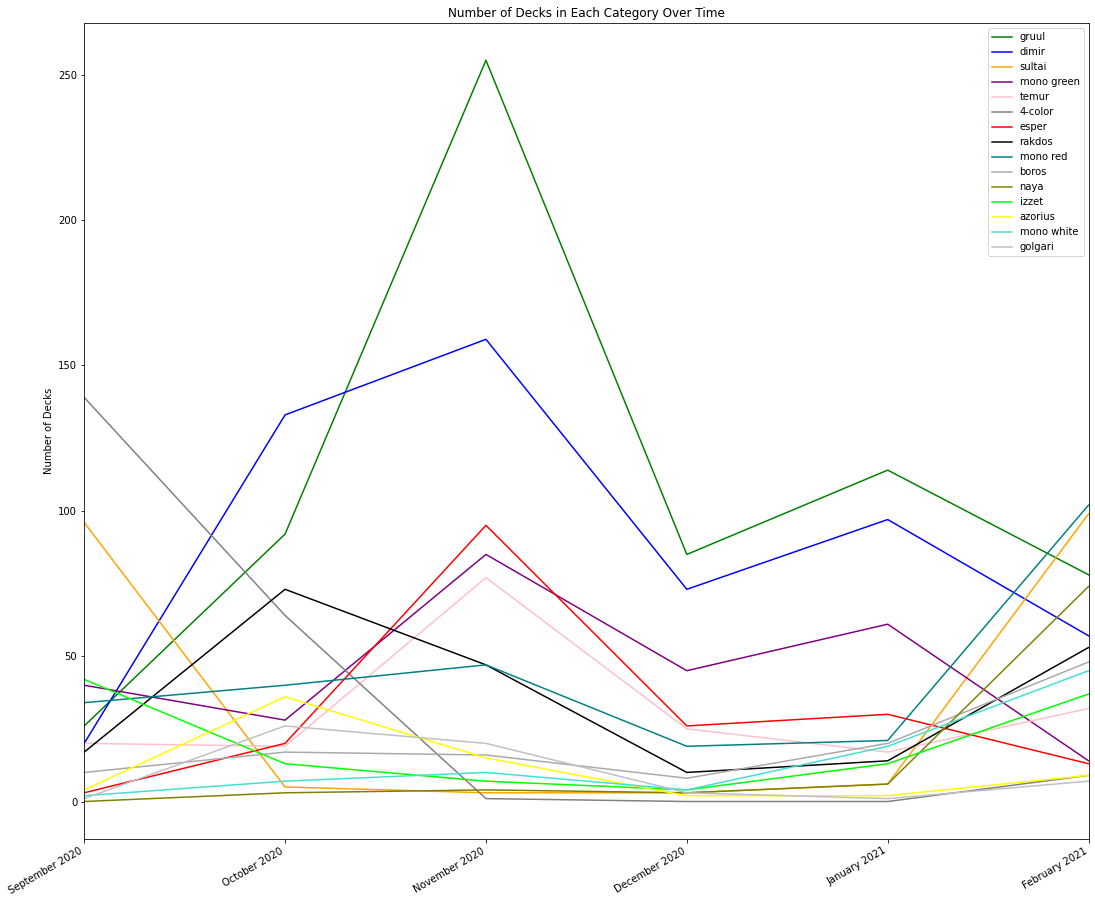

In [32]:
def categories_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "category"])["deckId"]
        .nunique()
        .reset_index()
    )
#     top_categories = this_df[
#         this_df["month_year"] == this_df["month_year"].max()
#     ]["category"].value_counts().index[:15]
    top_categories = this_df["category"].value_counts().index[:15]
    colors = ["green", "blue", "orange", "purple", "pink",
              "grey", "red", "black", "teal", "darkgrey",
              "olive", "lime", "yellow", "turquoise", "silver"
             ]
    plt.figure(figsize=(18, 15))
    for cat, color in zip(top_categories, colors):
        cat_df = grouped_df[grouped_df["category"]==cat]
        plt.plot(cat_df["month_year"], cat_df["deckId"], label=cat, color=color)
    
    plt.xticks(rotation=30, ha="right")
    plt.xlim(["September 2020", "February 2021"])
    plt.ylabel("Number of Decks")
    plt.title("Number of Decks in Each Category Over Time")
    plt.legend()
    if show:
        plt.show()
    
categories_over_time(full_table, show=True)

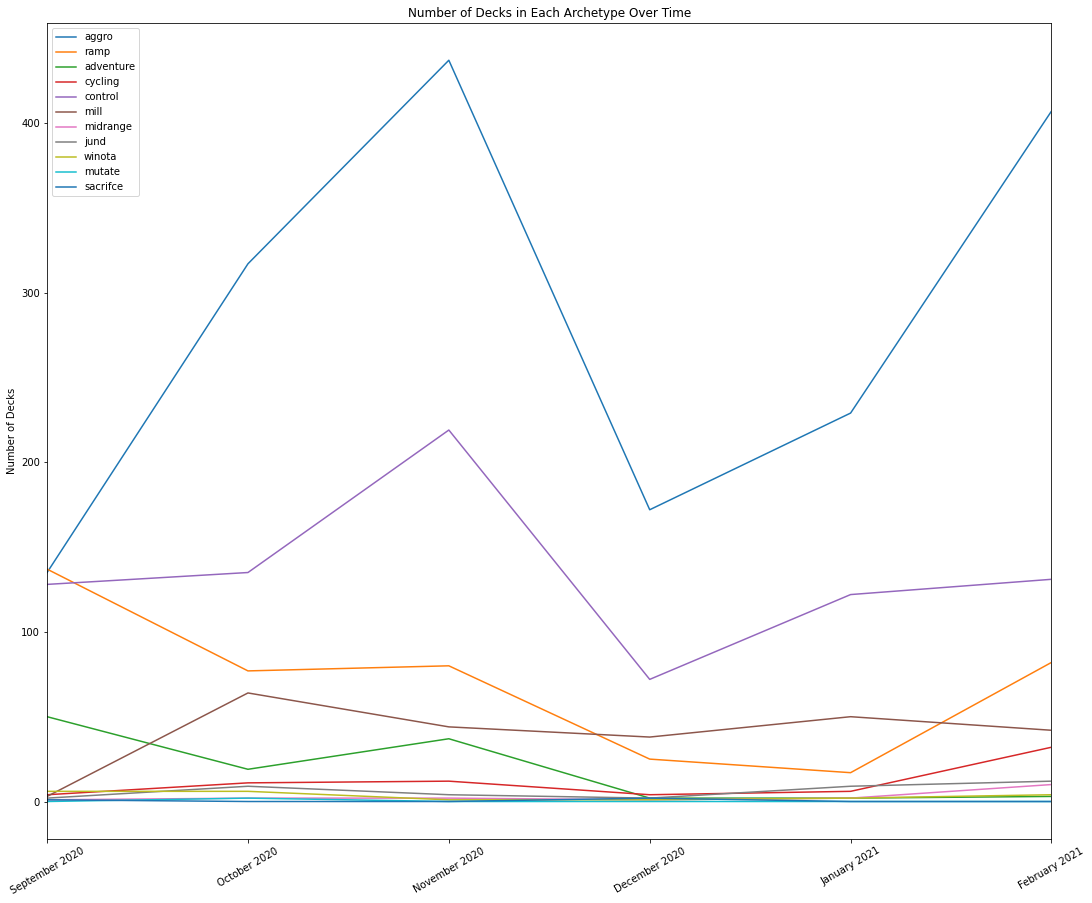

In [33]:
def archetypes_over_time(df, show=False):
    this_df = sort_by_date(df)
    
    grouped_df = (
        this_df
        .groupby(["month_year", "archetype"])["deckId"]
        .nunique()
        .reset_index()
    )
    top_archetypes = this_df[
        this_df["month_year"] == this_df["month_year"].max()
    ]["archetype"].value_counts().index[:15]
    
    plt.figure(figsize=(18, 15))
    for archetype in top_archetypes:
        archetype_df = grouped_df[grouped_df["archetype"]==archetype]
        plt.plot(archetype_df["month_year"], archetype_df["deckId"], label=archetype)
    
    plt.title("Number of Decks in Each Archetype Over Time")
    plt.xticks(rotation=30)
    plt.xlim(["September 2020", "February 2021"])   
    plt.ylabel("Number of Decks")
    plt.legend()
    if show:
        plt.show()
    
archetypes_over_time(full_table, show=True)

In [34]:
def arena_vs_nonarena(df):
    this_df = df.copy()
    this_df["is_arena"] = df.apply(lambda x: "arena" if "arena" in x["name_event"].lower() else "not_arena", axis=1)
    arena_freq = pd.crosstab(this_df["archetype"], this_df["is_arena"])
    _, pval, _, _ = chi2_contingency(arena_freq)
    return pval
    

In [35]:
masked_table = full_table.copy()

cat_count = masked_table["category"].value_counts()

mask = masked_table["category"].isin(cat_count[cat_count < 2000].index)

masked_table["category"][mask] = "other"

masked_table

<ipython-input-35-443826df187f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masked_table["category"][mask] = "other"


,eventId,name_event,date,deckId,pilotId,name_deck,firstName,lastName,cardId,name,count,color,slot,archetype,category,latest_set
0,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,261znr,Cragcrown Pathway // Timbercrown Pathway,4,GR,md,aggro,gruul,Zendikar Rising
1,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,244eld,Fabled Passage,4,NaN,md,aggro,gruul,Zendikar Rising
2,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,266eld,Forest,9,G,md,aggro,gruul,Zendikar Rising
3,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,262eld,Mountain,5,R,md,aggro,gruul,Zendikar Rising
4,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,115eld,Bonecrusher Giant // Stomp,4,R,md,aggro,gruul,Zendikar Rising
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105124,729,CFB Pro Showdown March 2021 @ Channelfireball,2021-03-13,3895,2170,Temur Aggro Adventure,Walker,Metyko,160m21,Soul Sear,2,R,sb,adventure,temur,Kaldheim
105125,729,CFB Pro Showdown March 2021 @ Channelfireball,2021-03-13,3895,2170,Temur Aggro Adventure,Walker,Metyko,135eld,Redcap Melee,1,R,sb,adventure,temur,Kaldheim
105126,729,CFB Pro Showdown March 2021 @ Channelfireball,2021-03-13,3895,2170,Temur Aggro Adventure,Walker,Metyko,237thb,Soul-Guide Lantern,2,NaN,sb,adventure,temur,Kaldheim
105127,729,CFB Pro Showdown March 2021 @ Channelfireball,2021-03-13,3895,2170,Temur Aggro Adventure,Walker,Metyko,228iko,"Obosh, the Preypiercer",1,BR,sb,adventure,temur,Kaldheim


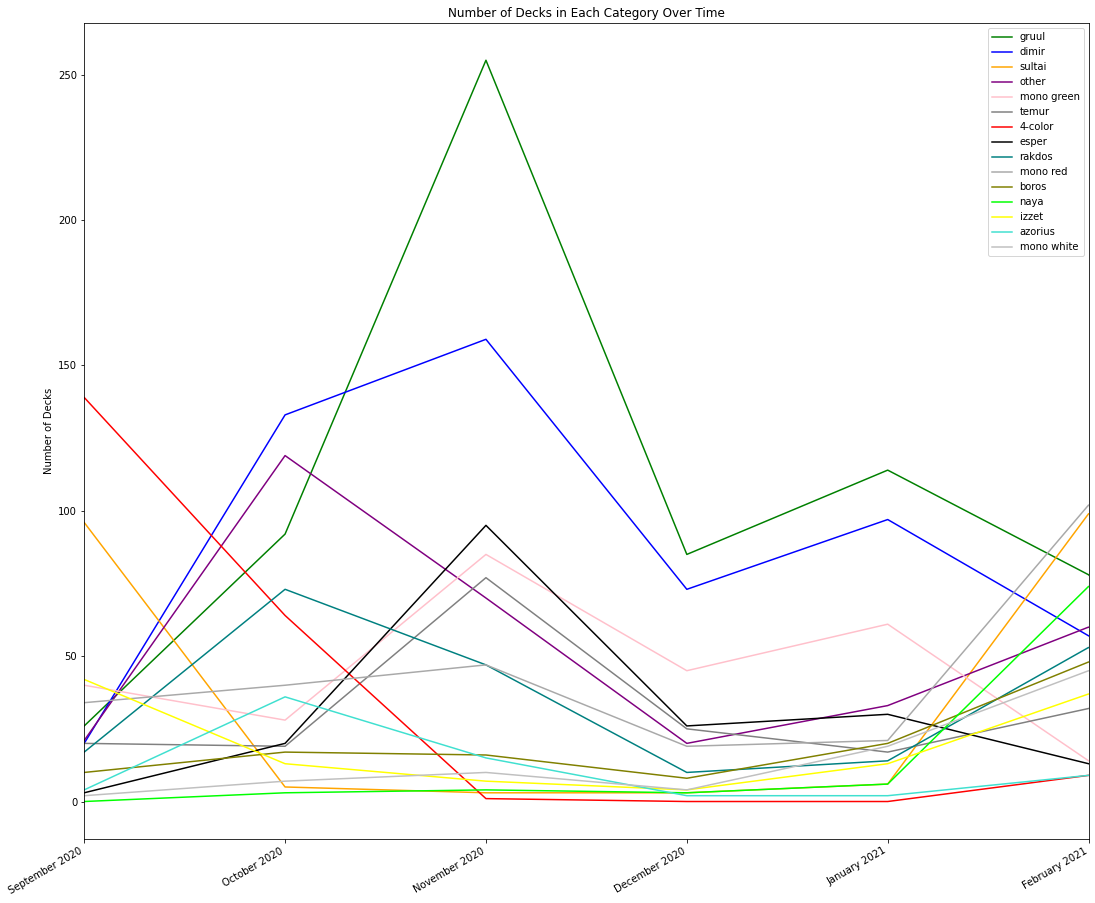

In [36]:
categories_over_time(masked_table)

In [37]:
def color_dominance(df, color, show=False):
    this_df = df.copy().fillna("")
    color_cards = this_df[
        (this_df["color"].str.contains(color))
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=color_cards, x="name", y="count")
    plt.xticks(rotation=80, ha="right")
    plt.subplots_adjust(bottom=0.3)
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    plt.title(f"Most Used {color.title()} Cards")
    if show:
        plt.show()

In [38]:
def plot_color_dominance(df, show=False, pdf=None):
    for color in ["W", "U", "B", "R", "G"]:
        color_dominance(df, color, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

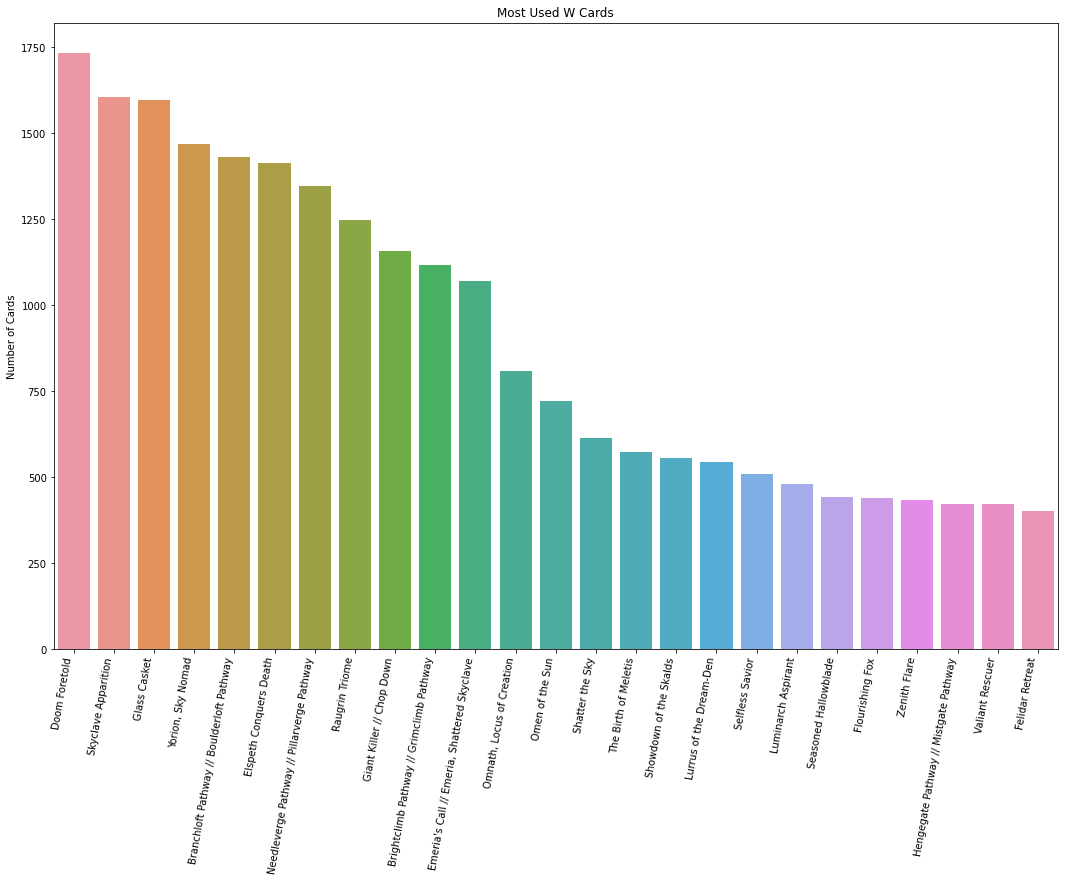

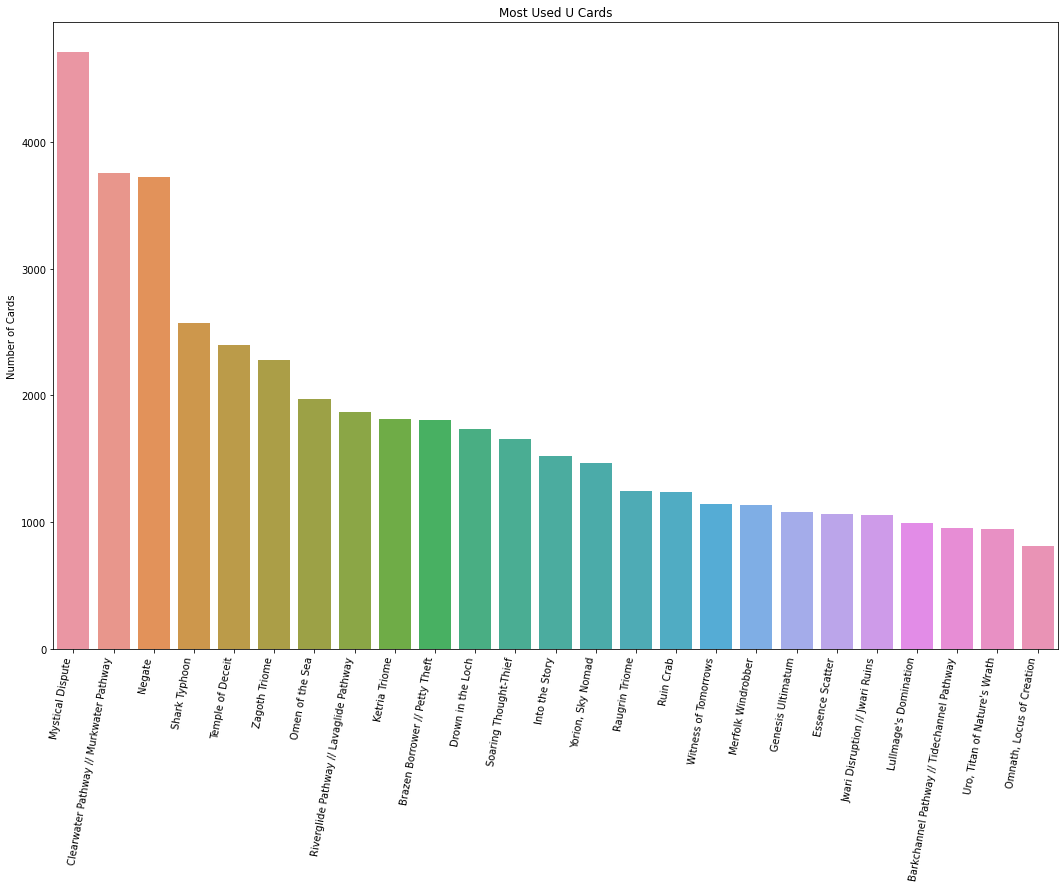

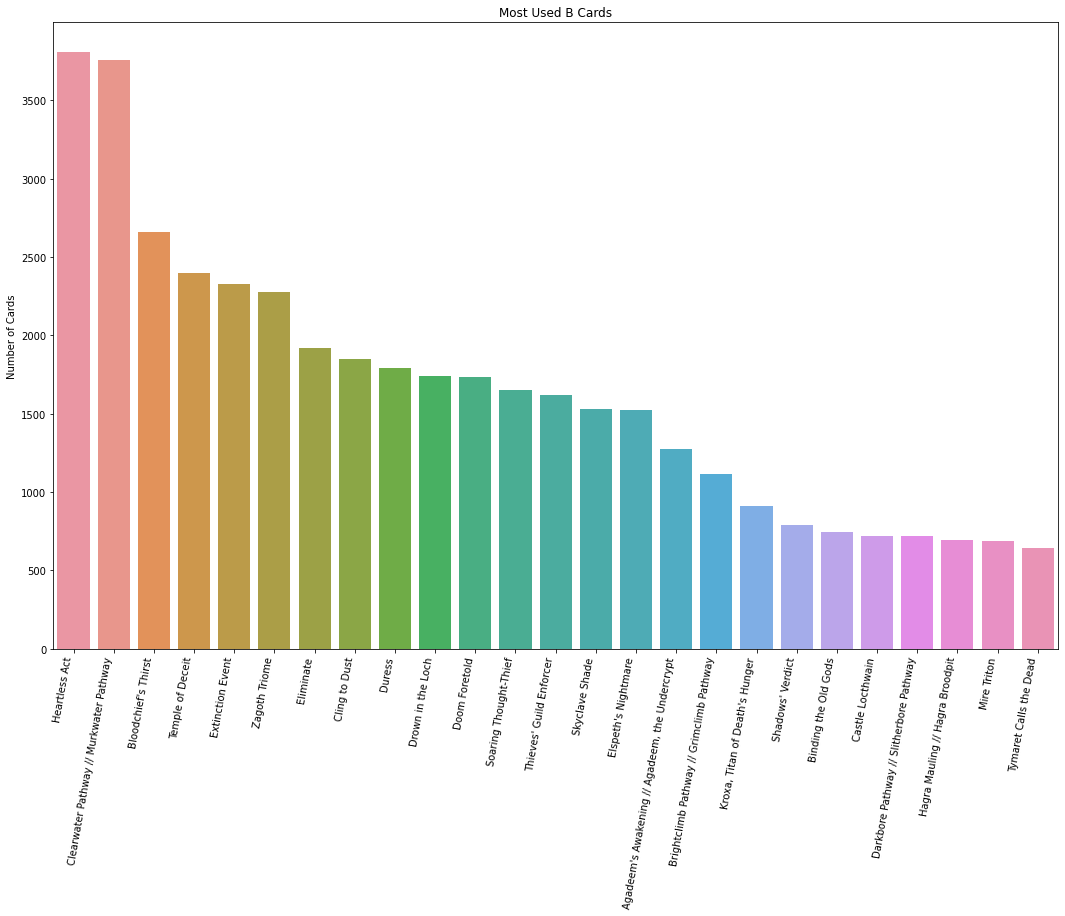

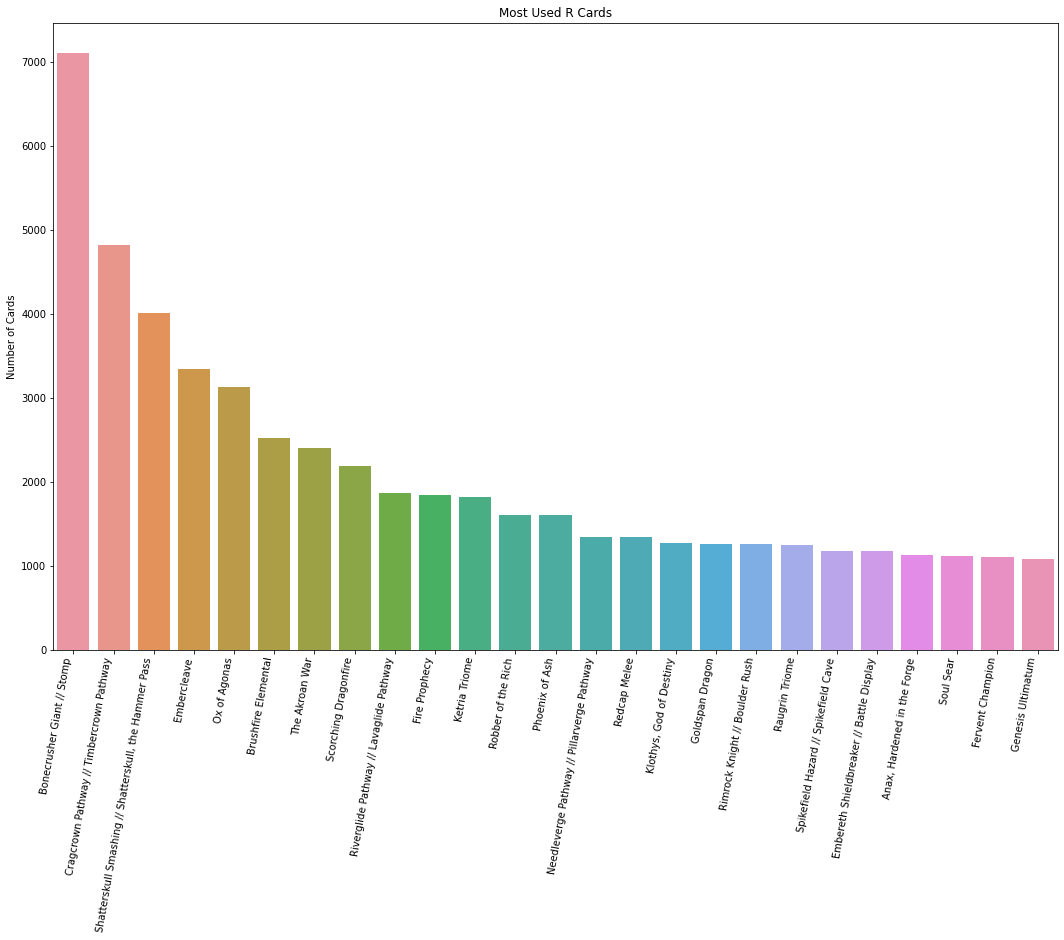

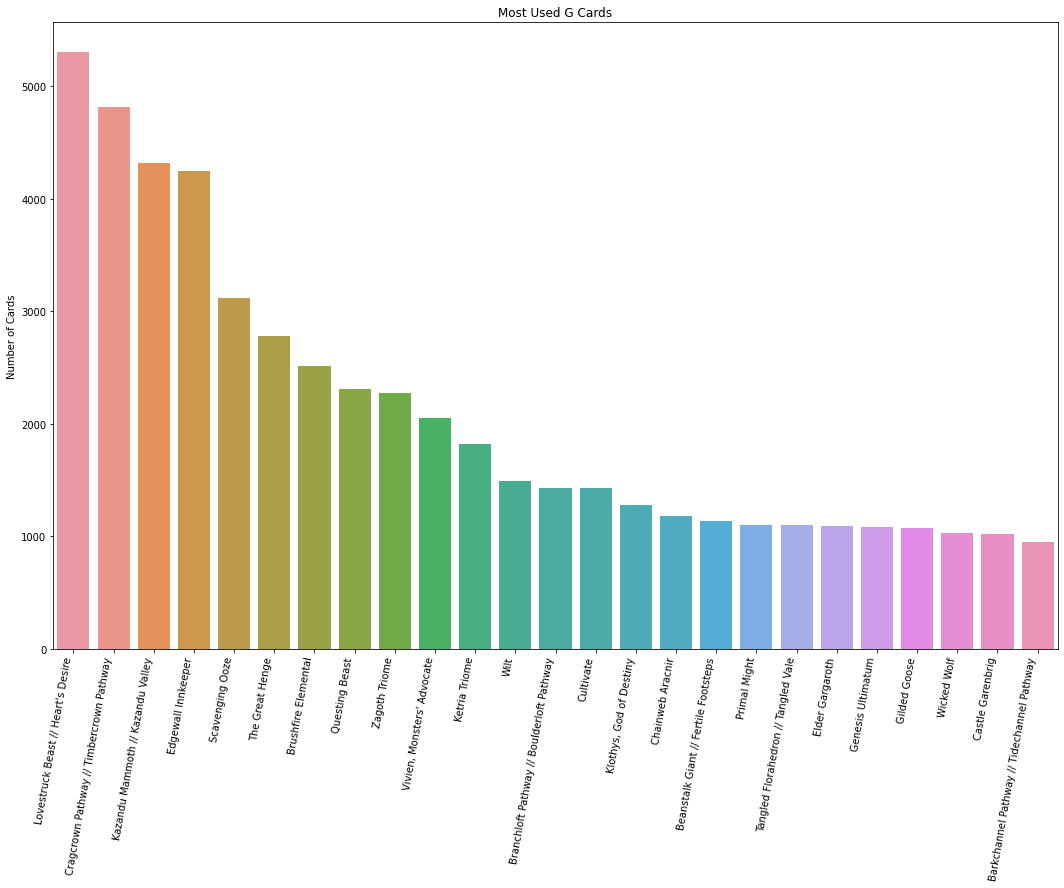

In [39]:
plot_color_dominance(full_table, show=True)

In [40]:
def set_dominance(df, set_code, show=False):
    this_df = df.copy().fillna("")
    this_df["set"] = this_df["cardId"].str.extract(r"(\d{3})(\w{3})")[1]
    set_df = this_df[
        (this_df["set"] == set_code)
        & (~this_df["name"].isin(["Forest", "Island", "Plains", "Swamp", "Mountain"]))
        & (~this_df["name"].str.contains("Snow-Covered"))
    ].groupby("name")["count"].sum().reset_index().sort_values(by="count", ascending=False).iloc[:25]
    plt.figure(figsize=(18, 15))
    sns.barplot(data=set_df, x="name", y="count")
    plt.xticks(rotation=80, ha="right")
    plt.subplots_adjust(bottom=0.3)
    plt.title(f"Most Used Cards from {set_code.title()} Set")
    plt.xlabel("")
    plt.ylabel("Number of Cards")
    if show:
        plt.show()

In [41]:
def plot_set_dominance(df, show=False, pdf=None):
    for set_code in ["eld", "thb", "iko", "znr", "m21", "khm"]:
        set_dominance(df, set_code, show)
        if pdf:
            pdf.savefig()
            plt.close("all")

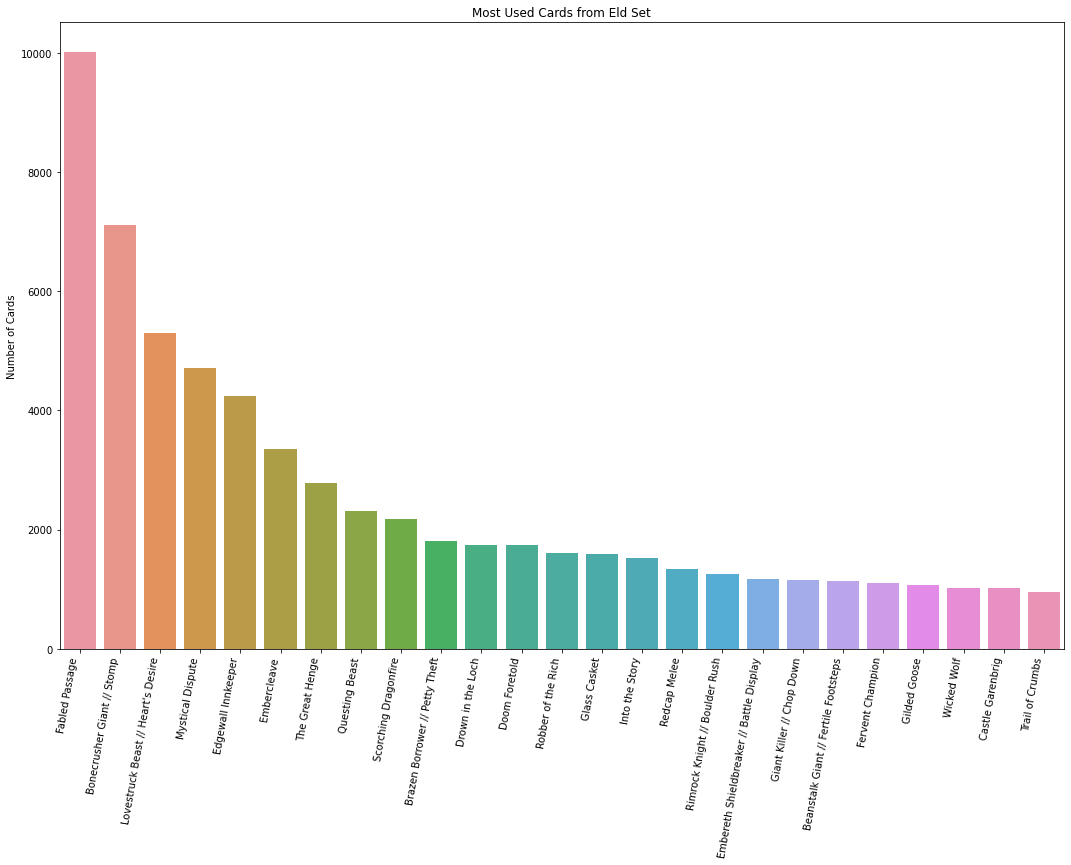

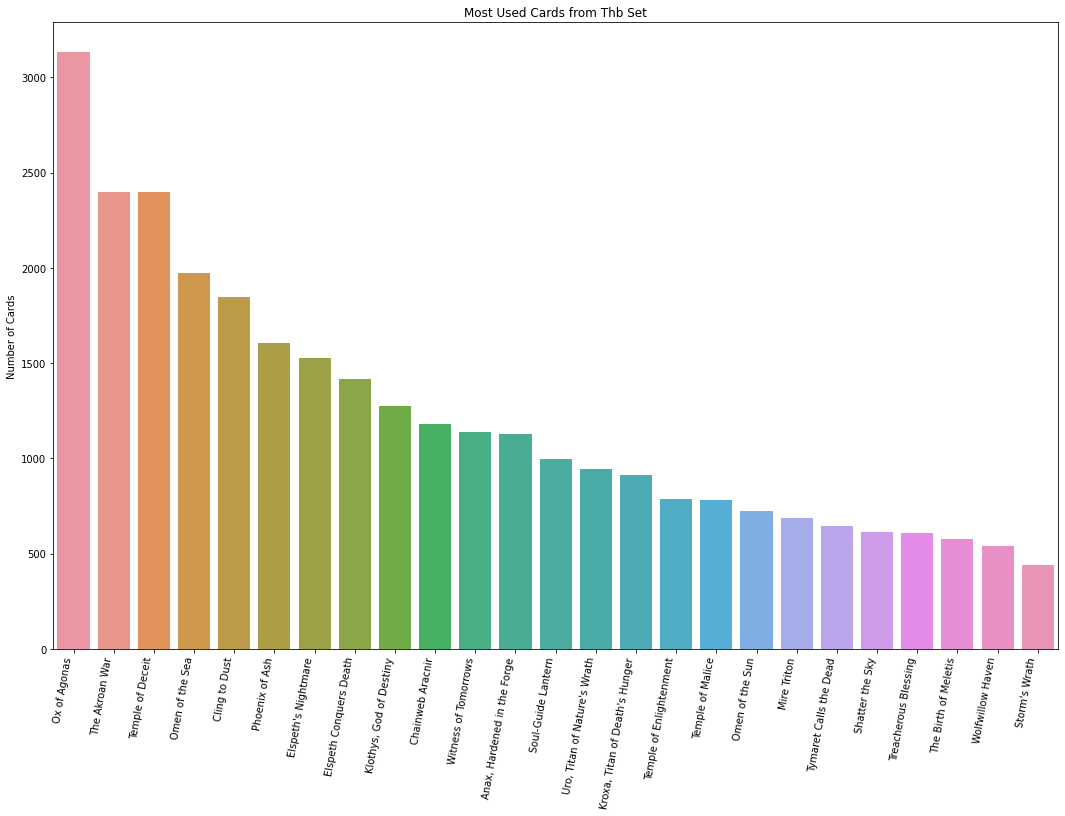

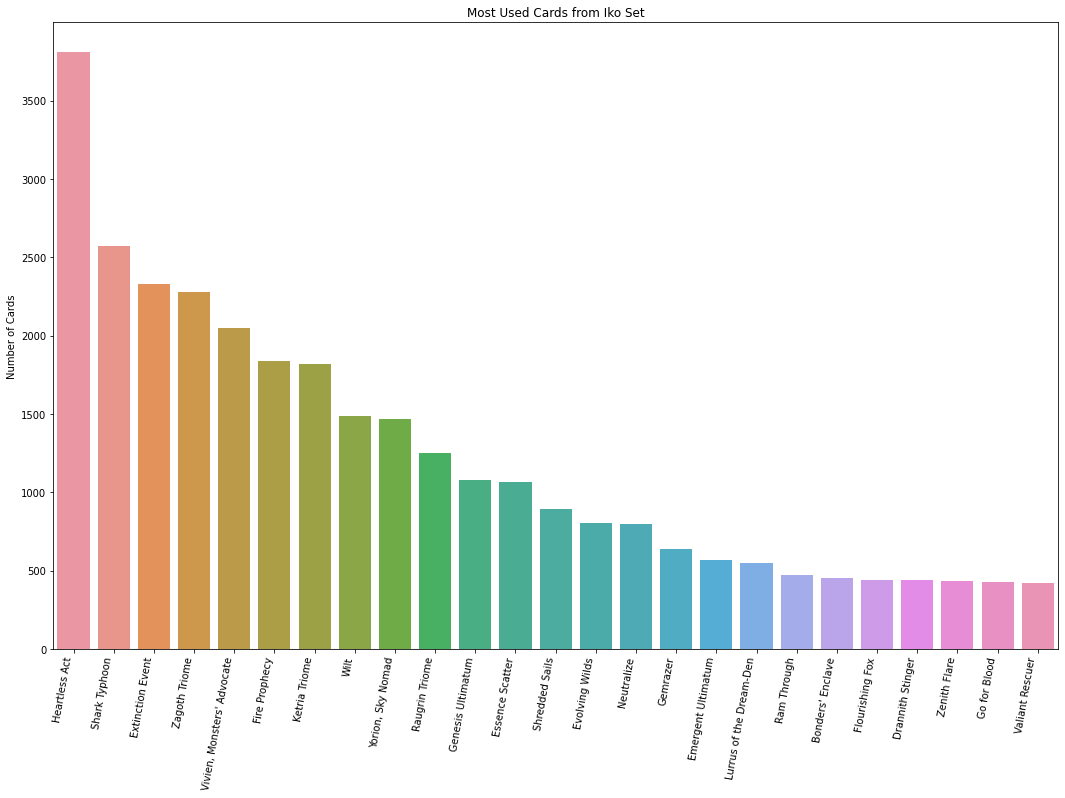

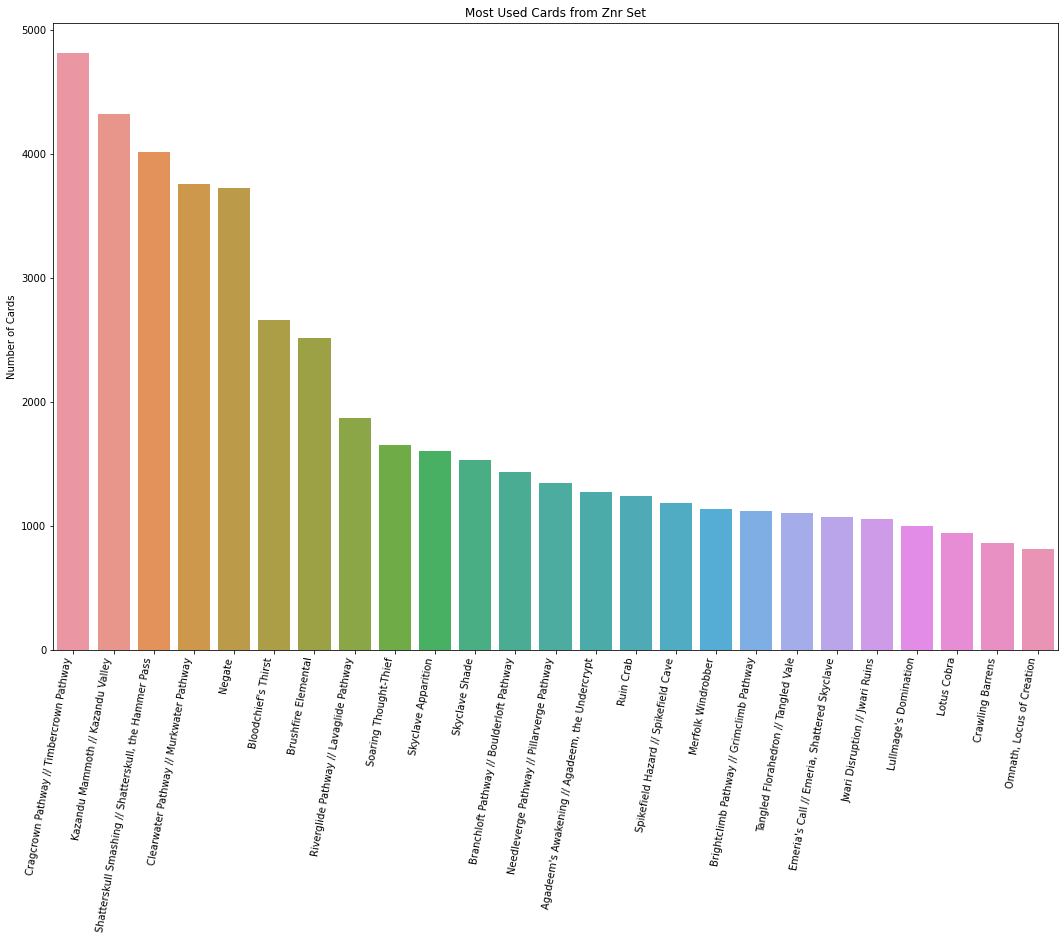

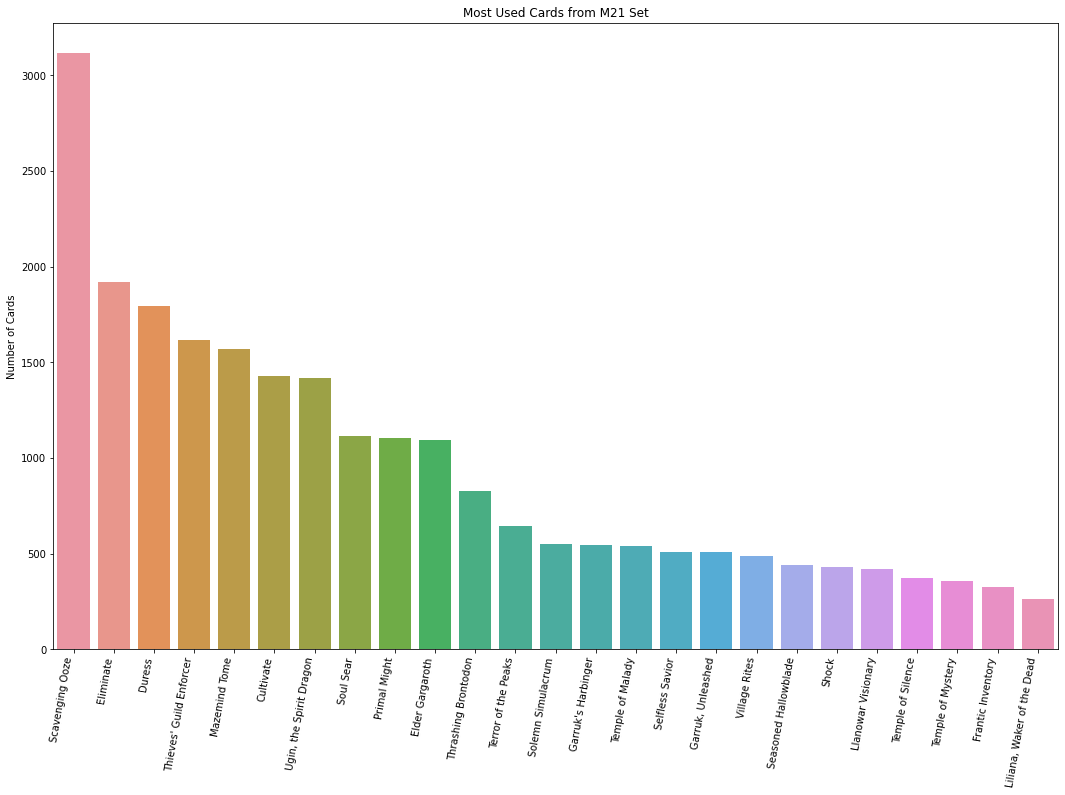

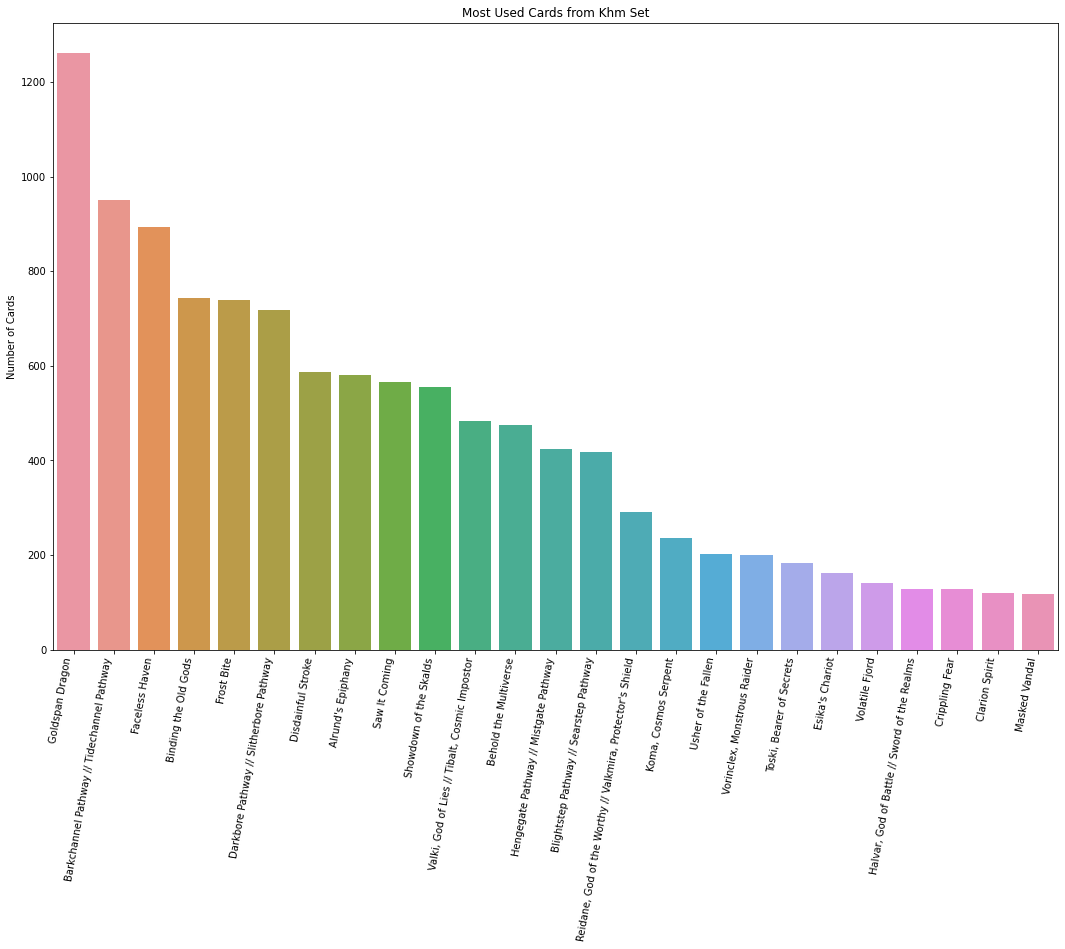

In [42]:
plot_set_dominance(full_table, show=True)

In [43]:
def oracle_text_analysis(df=most_used_cards):
    this_df = (
        df[["name"]]
        .merge(card_table[["name", "oracle_text"]], on="name", how="left")
        .drop_duplicates()
        .copy()
    )
    return this_df[
        (~this_df["name"].str.contains("Triome|Pathway|Fabled Passage", regex=True))
    ]

In [44]:
oracle_texts = oracle_text_analysis()

In [45]:
def get_part_of_speech(word):
    
    # wordnet.synsets(word) returns a list of all the available synonyms in ntlk corpus
    probable_part_of_speech = wordnet.synsets(word)

    pos_counts = Counter()
    
    # Gets the number of times each word is labeled as "n", "v", "a", or "r" in synsets
    pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
    
    # The most common item in Counter is the one with the most synsets of a particular pos
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

In [46]:
def process_text(text):
    cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', "", text)
    tokenized = word_tokenize(cleaned)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    return [word.lower() for word in lemmatized if word not in stop_words]

In [47]:
def get_tf_idf_scores(corpus):
    processed_corpus = [process_text(text) for text in corpus]
    vectorizer = TfidfVectorizer(norm=None, lowercase=None)
    tfidf_scores = vectorizer.fit_transform(processed_corpus)
    return tfidf_scores

In [48]:
texts = oracle_texts["oracle_text"].fillna("").tolist()
# processed_texts = [process_text(text) for text in texts]

In [49]:
test_vectorizer = TfidfVectorizer(norm=None, stop_words=stopwords.words("english"))
tfidf_scores = test_vectorizer.fit_transform(texts)

In [50]:
# test_vectorizer.get_feature_names()

# test_vectorizer.vocabulary_

In [51]:
corpus = " ".join(oracle_texts["oracle_text"].fillna(""))

In [52]:
def make_ngram_df(text_series, n):
    text_series = text_series.fillna("")
    text = " ".join(text_series)
#     cleaned = re.sub(r'[\.\?\!\,\:\;\"\{\}\/\-•\(\)—\\\']', '', text)
#     tokenized = word_tokenize(cleaned)
    
#     lemmatizer = WordNetLemmatizer()
#     lemmatized = [lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized]
    
#     stop_words = set(stopwords.words("english") + ["ca", "n't", "wa", "le", "'s", "they", "you"])
    
    real_text = process_text(text)
    
    bigrams = [" ".join(gram) for gram in ngrams(real_text, n)]
    
    freq = Counter(bigrams)
    
    df = (
        pd.DataFrame(
            {
                "bigram": freq.keys(),
                "freq": freq.values()
            }
        )
        .sort_values(by="freq", ascending=False)
        .iloc[:100]
    )
    df["pct_total"] = df["freq"] / df["freq"].sum() * 100
    
    return df

In [53]:
bigrams = make_ngram_df(oracle_texts["oracle_text"], 2)

trigrams = make_ngram_df(oracle_texts["oracle_text"], 3)

unigrams = make_ngram_df(oracle_texts["oracle_text"], 1)

In [54]:
def topn_analyze_card_text_by_archetype(df, n=10, show=False, pdf=None):
    topn_archetypes = df["archetype"].value_counts().index[:n]
    for archetype in topn_archetypes:
        archetype_df = get_most_used_cards(df[df["archetype"]==archetype])
        oracle_text_df = oracle_text_analysis(archetype_df)
        bigrams = make_ngram_df(oracle_text_df["oracle_text"], 2)
        plt.figure(figsize=(18, 15))
        sns.barplot(data=bigrams.iloc[:10], x="bigram", y="pct_total")
        plt.title(f"Bigrams for {archetype.title()}")
        plt.xticks(rotation=80)
        plt.xlabel("")
        plt.ylabel("Percent of Total")
        if show:
            plt.show()
        if pdf:
            pdf.savefig()
            plt.close("all")

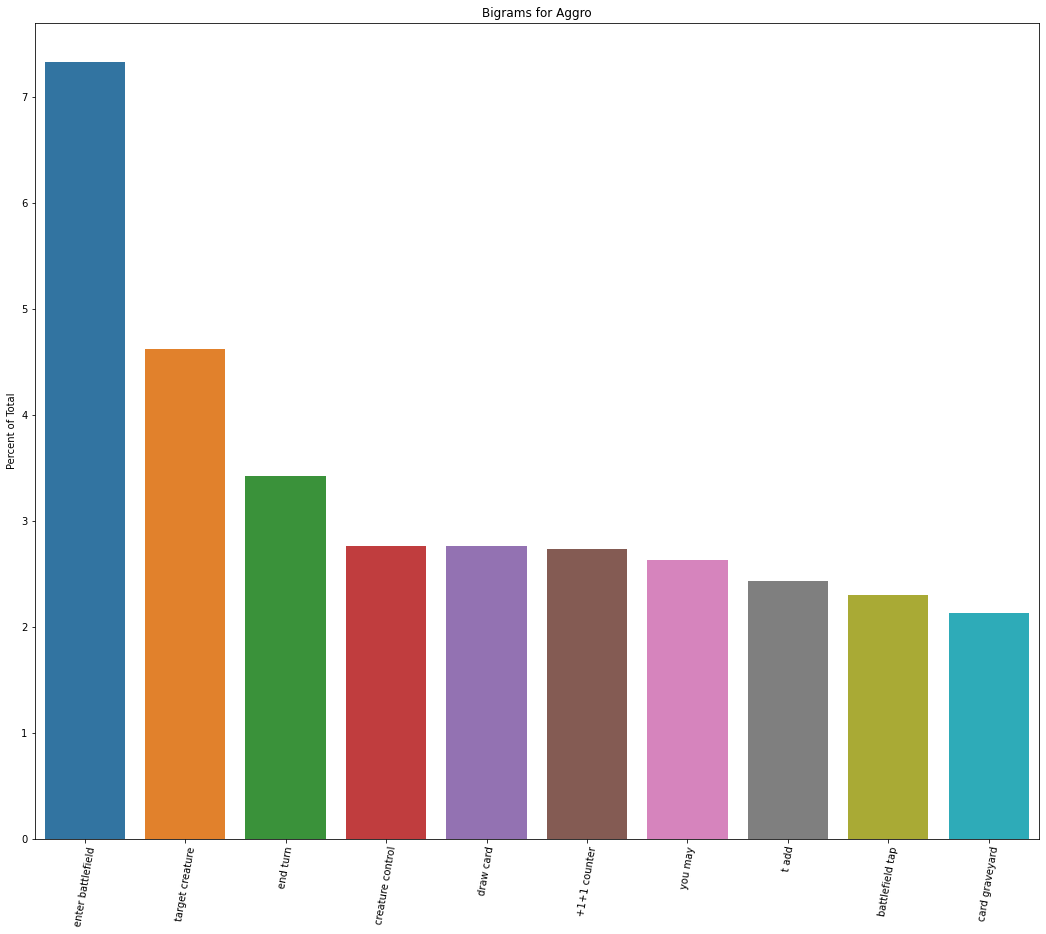

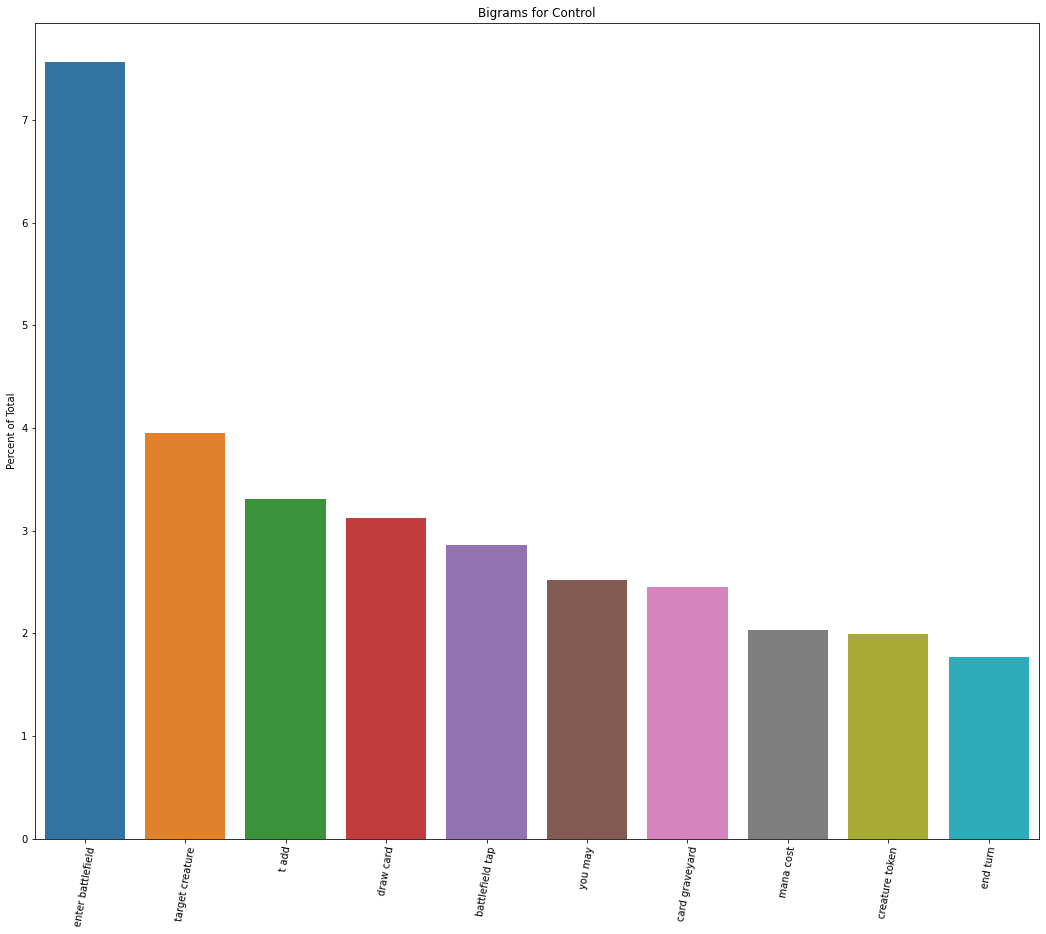

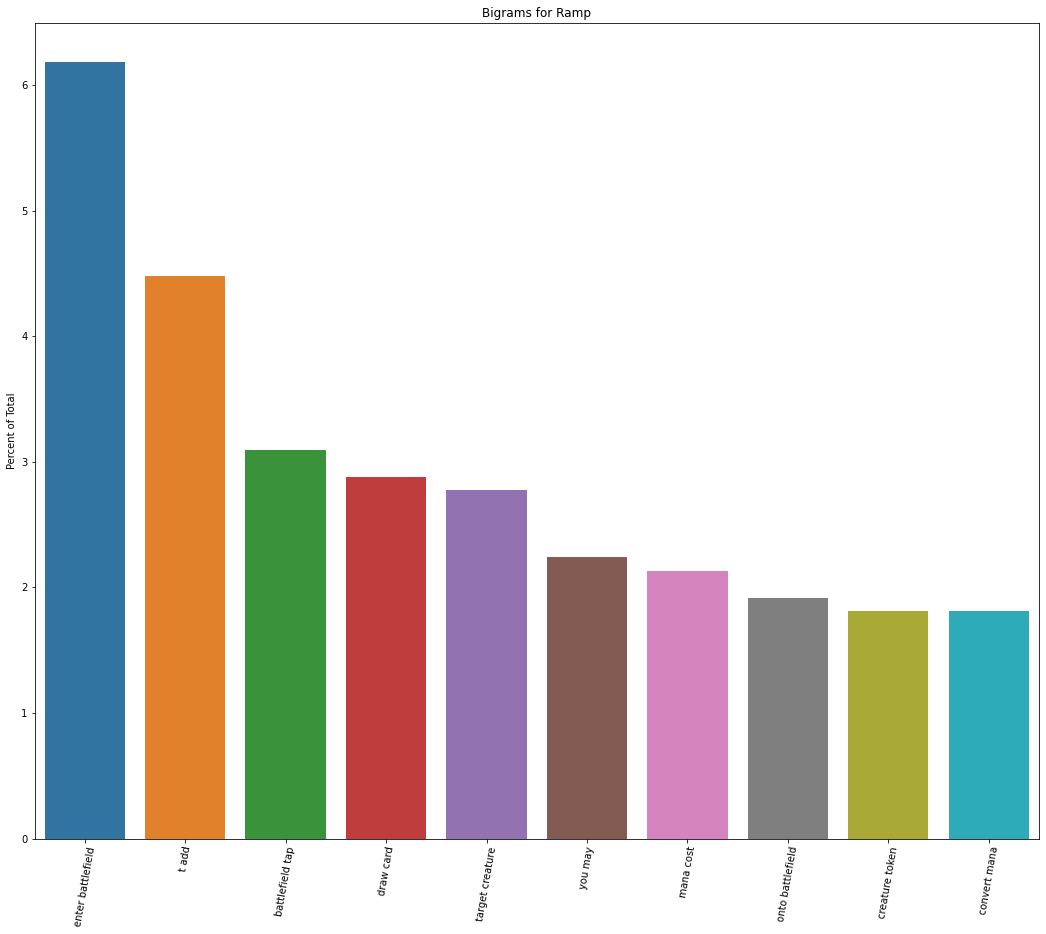

In [55]:
topn_analyze_card_text_by_archetype(main_decks, n=3, show=True)

In [56]:
full_table_oracle_text = oracle_text_analysis(full_table)

In [57]:
make_ngram_df(full_table_oracle_text["oracle_text"], 2)

,bigram,freq,pct_total
36,enter battlefield,409,6.983097
114,target creature,272,4.644016
42,end turn,186,3.175687
83,you may,164,2.800068
129,+1+1 counter,163,2.782995
49,draw card,161,2.748848
97,creature control,154,2.629332
0,t add,134,2.287861
123,card graveyard,133,2.270787
63,battlefield tap,115,1.963463


In [58]:
all_card_bigrams = make_ngram_df(card_table["oracle_text"], 2)

In [59]:
tstat, pval = ttest_1samp(bigrams["freq"], np.mean(all_card_bigrams["freq"]))

In [60]:
pval

3.831642528938944e-109

In [61]:
def save_to_pdf():
    with PdfPages("MTG Viz.pdf") as pdf:
        most_winning_archetypes()
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        most_winning_colors_by_set(first_place_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_colors_archetypes(first_place_decks, n=3, pdf=pdf)
        plt.close("all")
        
        most_used_cards_graphics(main_decks)
        pdf.savefig()
        plt.close("all")
        
        topn_archetypes(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        topn_categories(main_decks, n=3, pdf=pdf)
        plt.close("all")
        
        cards_by_set(main_decks)
        pdf.savefig()
        plt.close("all")
        
        cards_by_set(main_decks, unique_cards=True)
        pdf.savefig()
        plt.close("all")
        
        number_of_decks_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        categories_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        archetypes_over_time(full_table)
        pdf.savefig()
        plt.close("all")
        
        plot_color_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        plot_set_dominance(full_table, pdf=pdf)
        plt.close("all")
        
        topn_analyze_card_text_by_archetype(main_decks, n=3, pdf=pdf)
        plt.close("all")

In [62]:
save_to_pdf()